In [1]:
import sys
import os
os.chdir(r'..')
sys.path.append(os.getcwd() + '/outputs')
sys.path.append(os.getcwd() + '/functions')
sys.path.append(os.getcwd() + '/data')

import pandas as pd
import numpy as np
import make_network as mn
import networkx as nx

from patsy import dmatrices

import matplotlib.pyplot as plt

import matplotlib
import seaborn as sbn 

import network_analysis as nal

import scipy.stats as st

%matplotlib inline

/Users/jmunday/Documents/Measles_NL


In [2]:
os.getcwd()

'/Users/jmunday/Documents/Measles_NL'

In [6]:
import igraph as ig

In [5]:
import importlib

In [3]:
vo_frame = pd.read_csv('data/Location data/vo_jan2013.csv', encoding='iso8859_15')
bo_frame = pd.read_csv('data/Location data/vo_jan2013.csv', encoding='iso8859_15')
so_frame = pd.read_csv('data/Location data/vo_jan2013.csv', encoding='iso8859_15')

In [4]:
all_frame = pd.concat([vo_frame, bo_frame, so_frame])

In [5]:
import transnet

In [6]:
from cdlib import algorithms, evaluation, ensemble


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'infomap', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [10]:
data_net_clean = transnet.data_net.subgraph(nodes=np.intersect1d(list(all_frame.vestigingsnummer),list(transnet.data_net.nodes())))

In [7]:
communities = []


resolution_parameter = ensemble.Parameter(name="resolution_parameter", start=0.1, end=1.1, step=0.1)
randomize = ensemble.BoolParameter(name="randomize", value=True)
weights = ensemble.Parameter(name="weights", start='weight')
params = [resolution_parameter, weights]

methods = [algorithms.rb_pots]

for community in ensemble.pool(transnet.data_net, methods, [params]):
    communities.append(community)

In [ ]:
?algorithms.rb_pots

In [8]:
significance = [evaluation.significance(transnet.data_net,community).score for community in communities]
ied = [evaluation.internal_edge_density(transnet.data_net,community).score for community in communities]
ng_modularity = [evaluation.newman_girvan_modularity(transnet.data_net,community).score for community in communities]
modularity_density = [evaluation.modularity_density(transnet.data_net,community).score for community in communities]
surprise = [evaluation.surprise(transnet.data_net,community).score for community in communities]

In [53]:
len(transnet.data_net.nodes())

9200

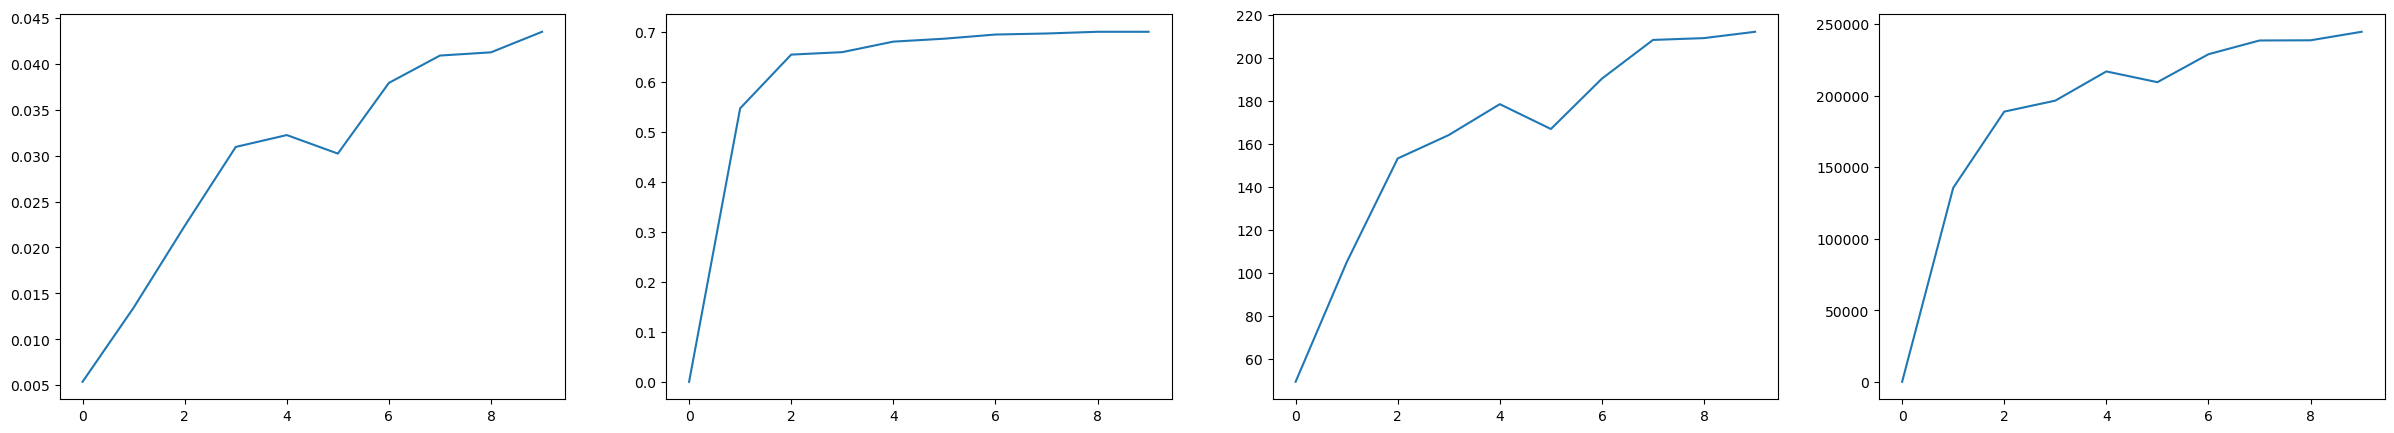

In [9]:
fig = plt.figure(figsize = [30,5])
ax = fig.add_subplot(141)
plt.plot(ied)
ax = fig.add_subplot(142)
plt.plot(ng_modularity)
ax = fig.add_subplot(143)
plt.plot(modularity_density)
ax = fig.add_subplot(144)
plt.plot(surprise)

In [10]:
leidens = [algorithms.leiden(transnet.data_net, weights='weight') for x in range(20)]

In [11]:
def calc_sim_mat(partitions):  

    parts = []
    for coms in partitions:
        part = dict()
        for i, com in enumerate(coms.communities):
            for n in com:
                part[n] = i
        parts.append(part)


    coms = []
    for i, com in enumerate(parts):

        part_frame = pd.DataFrame.from_dict(parts[i], orient='index').reset_index()
        part_frame.columns = ['BRIN', 'Part']
        coms.append(list(part_frame.sort_values('BRIN').Part))


    summed_mats = np.zeros([len(coms[0]), len(coms[0])]) 
    for i, com in enumerate(coms):
        print ('Set ', i)
        summed_mats = summed_mats + np.array([list(np.array(com) == com[n]) for n in range(len(com))])

    sim_mat = summed_mats/float(len(partitions))
    
    return(sim_mat, list(part_frame.sort_values('BRIN').BRIN))
    

In [12]:
sim_mat_all, nodelist_sm = calc_sim_mat(leidens)

Set  0
Set  1
Set  2
Set  3
Set  4
Set  5
Set  6
Set  7
Set  8
Set  9
Set  10
Set  11
Set  12
Set  13
Set  14
Set  15
Set  16
Set  17
Set  18
Set  19


In [13]:
np.fill_diagonal(sim_mat_all,0)

In [14]:
sim_net_all = transnet.create_network_from_transmat(sim_mat_all, nodelist_sm)

In [23]:
consensuses_all = [algorithms.leiden(sim_net_all, weights='weight') for x in range(20)]

KeyboardInterrupt: 

In [ ]:
sim_mat_cons_all, nodelist_sm = calc_sim_mat(consensuses_all)

In [ ]:
sim_net_2_all = transnet.create_network_from_transmat(sim_mat_cons_all, nodelist_sm)

In [ ]:
consensuses_2_all = [algorithms.leiden(sim_net_2_all, weights='weight') for x in range(10)]

In [ ]:
sim_mat_cons_2_all, nodelist_sm = calc_sim_mat(consensuses_2_all)

In [ ]:
consensuses_all

In [20]:
nmi_table = []
for j in range(20):
    row = []
    for i in range(20):
        row.append(leidens[j].normalized_mutual_information(leidens[i]).score)
    nmi_table.append(row)

Text(0.5, 1.0, 'NMI matrix - Initial partitions')

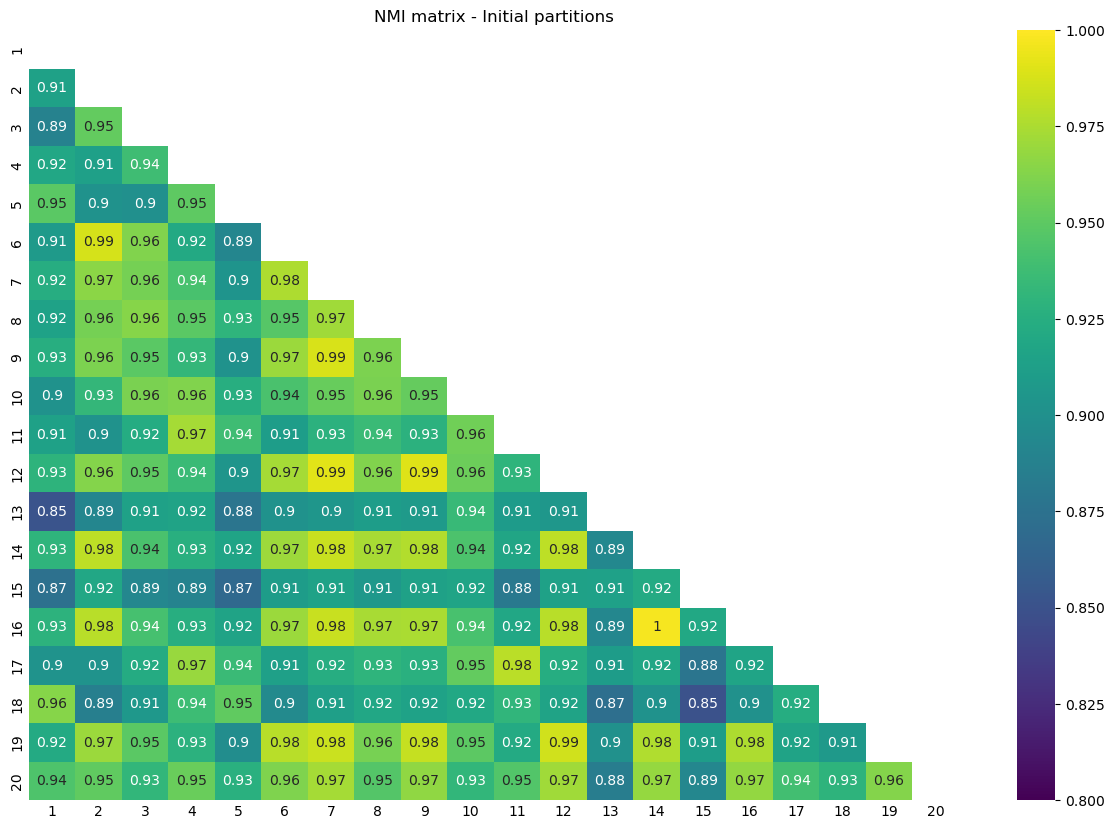

In [21]:
import seaborn as sns
mask = np.triu(np.ones_like(nmi_table, dtype=bool))
fig = plt.figure(figsize=[15,10])
sns.heatmap(pd.DataFrame(nmi_table), annot=True, vmin=0.8, vmax=1., cmap='viridis', mask=mask)
plt.xticks(np.arange(20)+0.5, range(1,21) )
plt.yticks(np.arange(20)+0.5, range(1,21) )
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('NMI matrix - Initial partitions')

Text(0.5, 1, 'NMI matrix - Initial partitions')

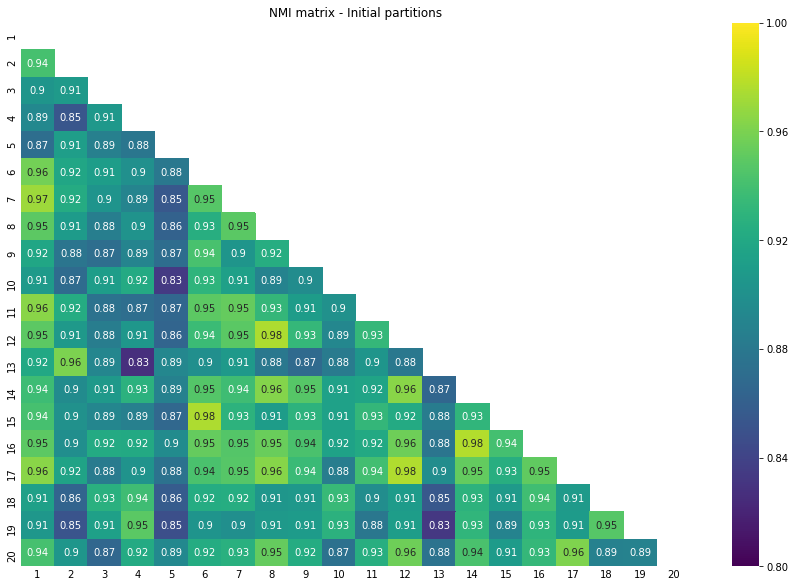

In [32]:
import seaborn as sns
mask = np.triu(np.ones_like(nmi_table, dtype=bool))
fig = plt.figure(figsize=[15,10])
sns.heatmap(pd.DataFrame(nmi_table), annot=True, vmin=0.8, vmax=1., cmap='viridis', mask=mask)
plt.xticks(np.arange(20)+0.5, range(1,21) )
plt.yticks(np.arange(20)+0.5, range(1,21) )
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('NMI matrix - Initial partitions')

In [37]:
nmi_table = []
for j in range(20):
    row = []
    for i in range(20):
        row.append(consensuses_all[j].normalized_mutual_information(consensuses_all[i]).score)
    nmi_table.append(row)

Text(0.5, 1, 'NMI matrix - First round consensus partitions ')

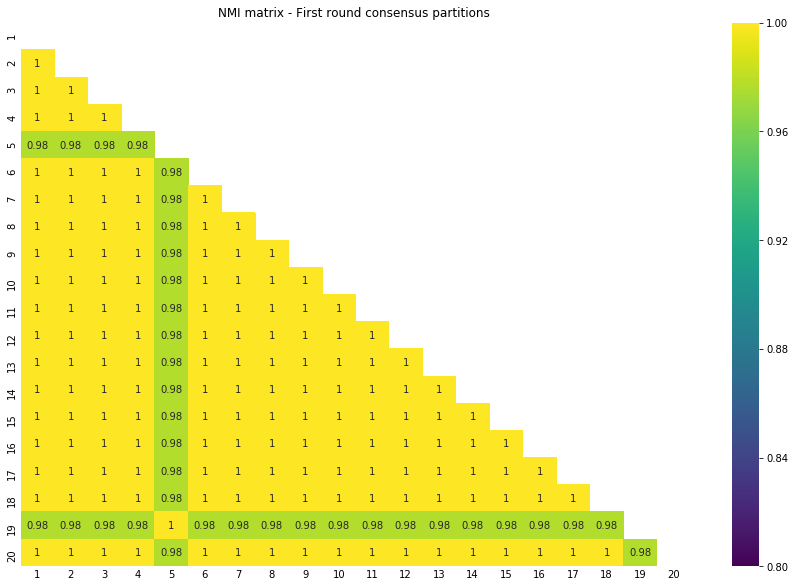

In [38]:
import seaborn as sns
mask = np.triu(np.ones_like(nmi_table, dtype=bool))
fig = plt.figure(figsize=[15,10])
sns.heatmap(pd.DataFrame(nmi_table), annot=True, vmin=0.8, vmax=1., cmap='viridis', mask=mask)
plt.xticks(np.arange(20)+0.5, range(1,21) )
plt.yticks(np.arange(20)+0.5, range(1,21) )
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('NMI matrix - First round consensus partitions ')

In [40]:
nmi_table = []
for j in range(10):
    row = []
    for i in range(10):
        row.append(consensuses_2_all[j].normalized_mutual_information(consensuses_2_all[i]).score)
    nmi_table.append(row)

Text(0.5, 1, 'NMI matrix - Second round consensus partitions ')

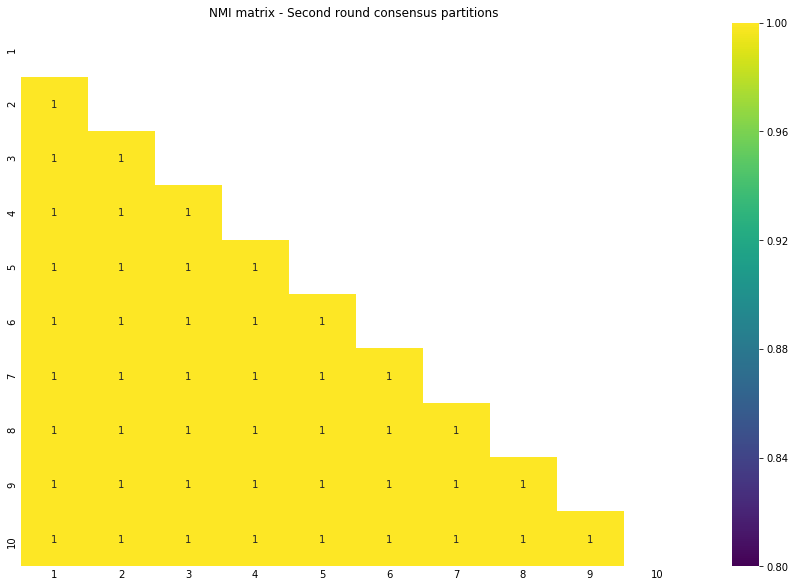

In [42]:
import seaborn as sns
mask = np.triu(np.ones_like(nmi_table, dtype=bool))
fig = plt.figure(figsize=[15,10])
sns.heatmap(pd.DataFrame(nmi_table), annot=True, vmin=0.8, vmax=1., cmap='viridis', mask=mask)
plt.xticks(np.arange(10)+0.5, range(1,11) )
plt.yticks(np.arange(10)+0.5, range(1,11) )
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('NMI matrix - Second round consensus partitions ')

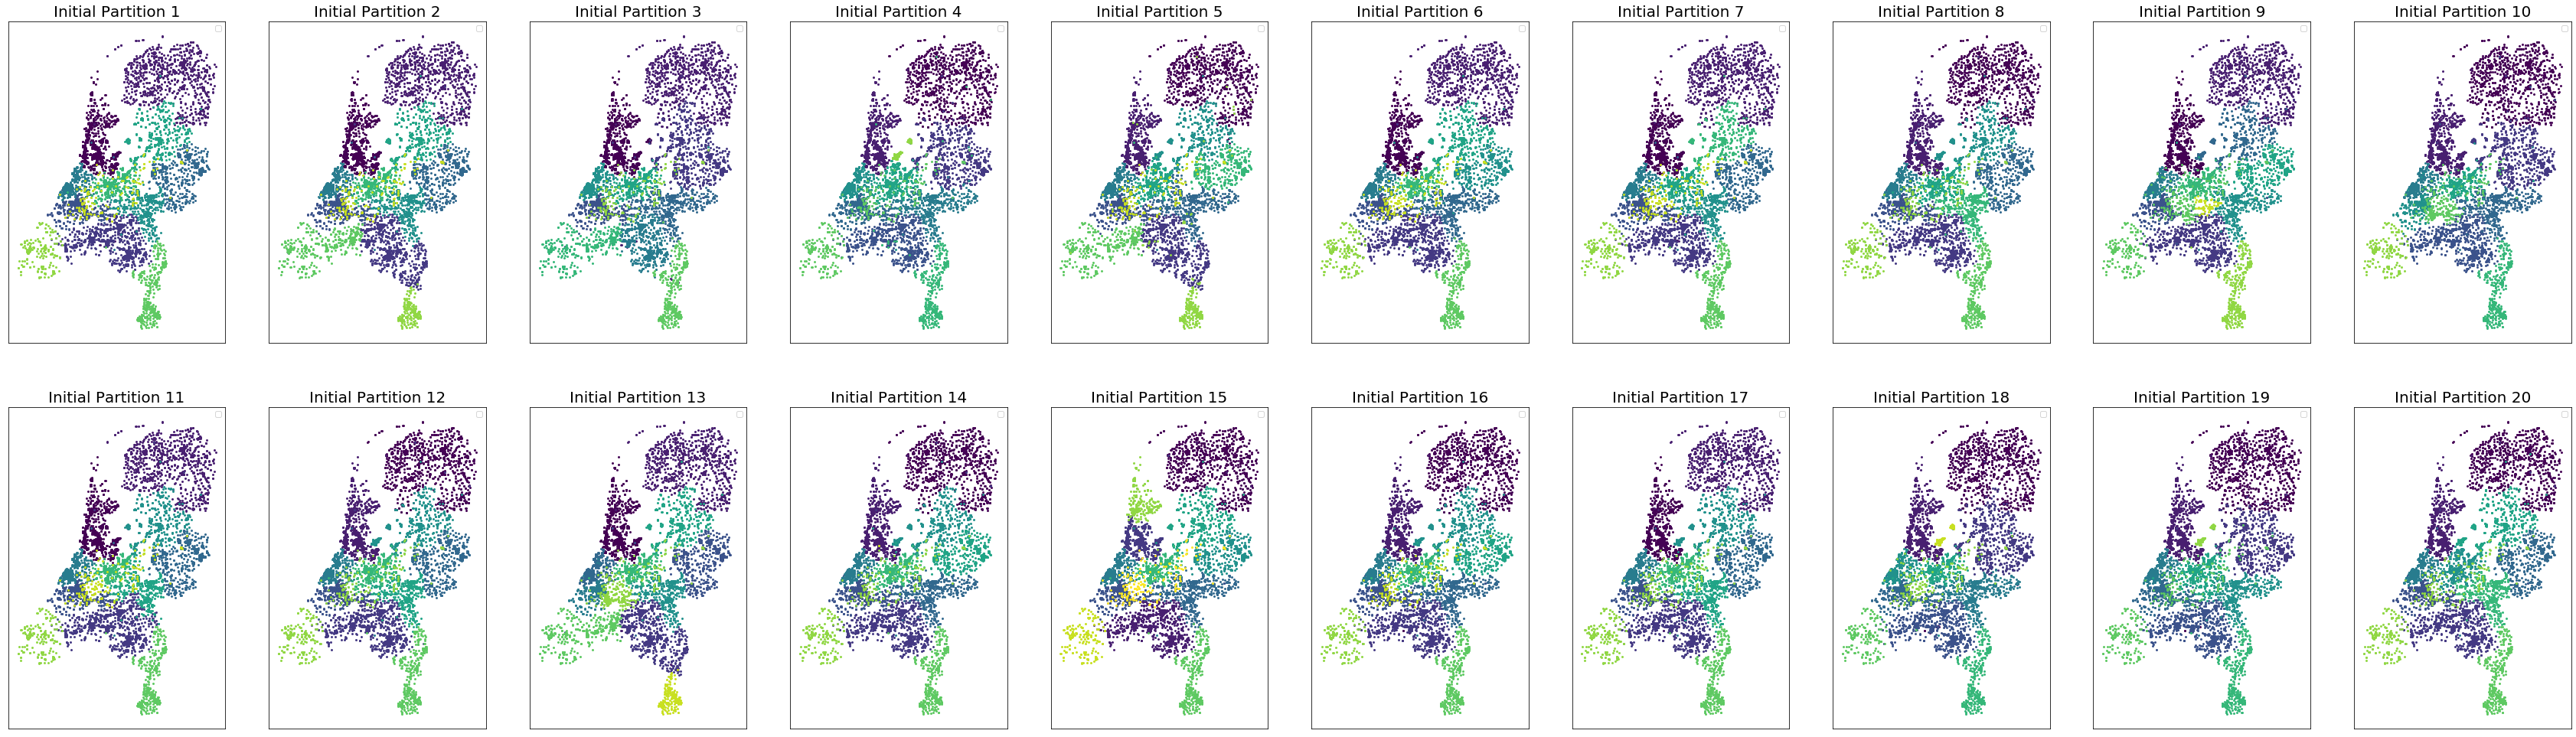

In [97]:
fig = plt.figure(figsize=[20*3,17])

for j , consensus in enumerate(leidens):
    school_data = transnet.school_data
    NUM_COLORS = 12
    cm = plt.get_cmap('viridis')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    ax=fig.add_subplot(2,10,j+1)

    for i, com in enumerate(consensus.communities): 

        
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Initial Partition ' + str(j + 1), fontsize=20)
        ax.legend([])

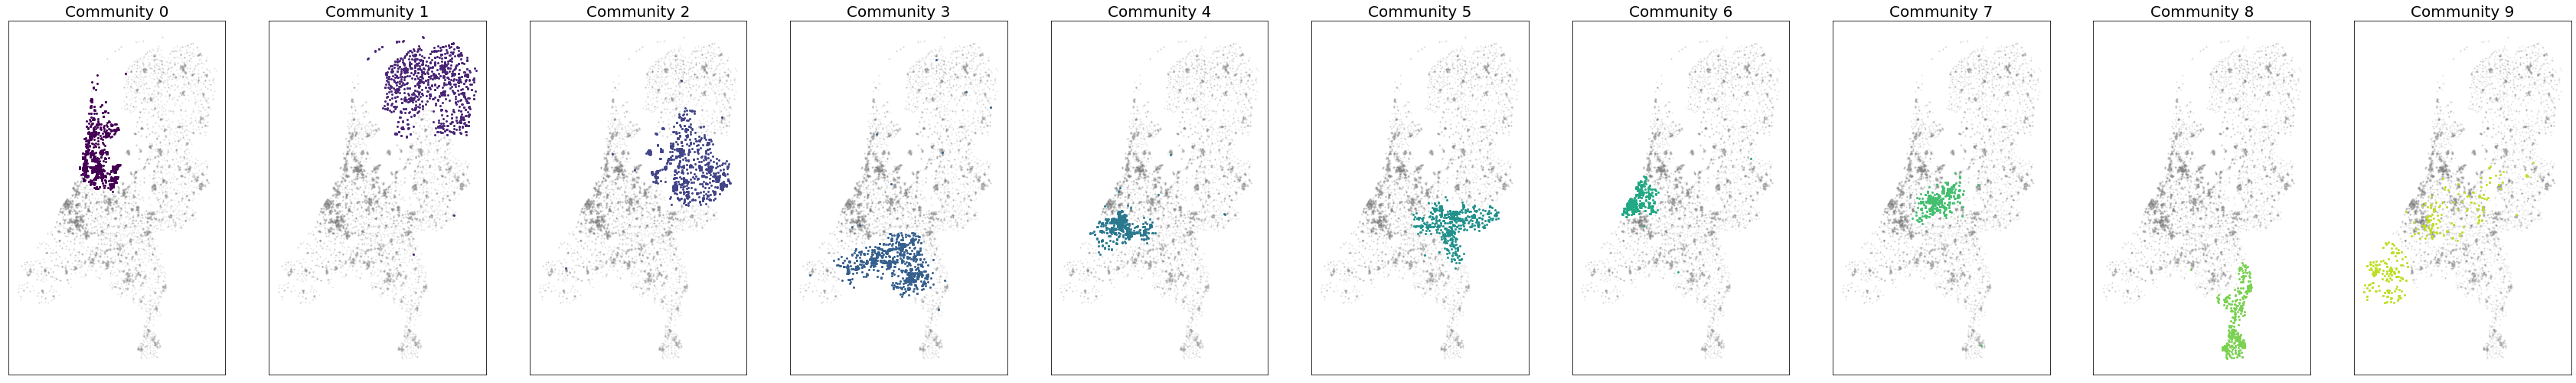

In [132]:
for consensus in [consensuses_2_all[0]] :
    school_data = transnet.school_data
    NUM_COLORS = 10
    cm = plt.get_cmap('viridis')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    fig = plt.figure(figsize=[20*3,17/2.])

    for i, com in enumerate(consensus.communities): 

        ax=fig.add_subplot(1,NUM_COLORS,i+1)
        pd.DataFrame(school_data).query('BRIN not in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=2, mfc='Grey', ax=ax, alpha=0.2, mew=0)
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Community ' + str(i), fontsize=20)
        ax.legend([], frameon=False)

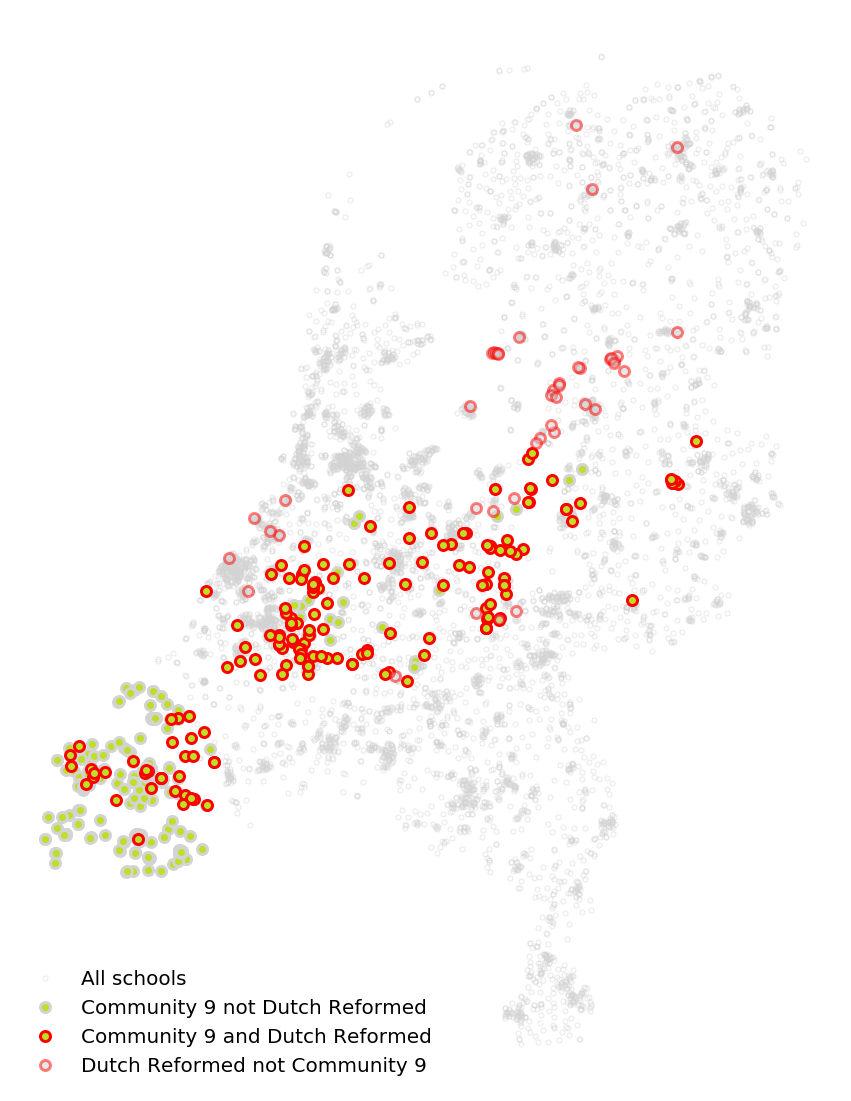

In [149]:
parts = []

for coms in consensuses_2_all:
    part = dict()
    for i, com in enumerate(coms.communities):
        for n in com:
            part[n] = i
    parts.append(part)

part_frame = pd.DataFrame.from_dict(parts[0], orient='index').reset_index()
part_frame.columns = ['BRIN', 'Part']
school_data_p = transnet.school_data.merge(part_frame, on='BRIN', how='right')


    
fig = plt.figure(figsize=[15,20])
ax=fig.add_subplot(111)


pd.DataFrame(school_data_p).query('Part != 9 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=5, mec='LightGrey', mfc='none', ax=ax, alpha=0.5)
pd.DataFrame(school_data_p).query('Part == 9 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc=cm(0.9), mec='LightGrey', mew=3., ax=ax, alpha=1.)
pd.DataFrame(school_data_p).query('Part == 9 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc=cm(0.9), mec='r', mew=3., ax=ax, alpha=1.)
pd.DataFrame(school_data_p).query('Part != 9 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc='LightGrey', mec='r', mew=3., ax=ax, alpha=0.5)



sns.despine(left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_title('', fontsize=20)
ax.legend(['All schools', 'Community 9 not Dutch Reformed','Community 9 and Dutch Reformed','Dutch Reformed not Community 9' ], fontsize=20, frameon=0)

In [193]:
school_data_p = transnet.school_data.merge(part_frame, on='BRIN', how='right')

In [15]:
parts = []

for coms in leidens:
    part = dict()
    for i, com in enumerate(coms.communities):
        for n in com:
            part[n] = i
    parts.append(part)

part_frame = pd.DataFrame.from_dict(parts[0], orient='index').reset_index()
part_frame.columns = ['BRIN', 'Part']
school_data_p = transnet.school_data.merge(part_frame, on='BRIN', how='right')

In [150]:
com2 = consensuses_2_all[0].communities[9]

In [159]:
school_data[(school_data.BRIN.isin(com2))].groupby(['provincie', 'Denomination']).count()[['BRIN']].rename(columns={'BRIN':"InCom"})

InCom
provincie     Denomination                   
Gelderland    Protestants-Christelijk       6
              Reformatorisch               42
Noord-Brabant Reformatorisch                3
Noord-Holland Reformatorisch                2
Overijssel    Reformatorisch                7
Utrecht       Protestants-Christelijk       4
              Reformatorisch               16
Zeeland       Algemeen bijzonder           19
              Antroposofisch                1
              Gereformeerd vrijgemaakt      3
              Openbaar                     79
              Overige                       1
              Protestants-Christelijk      56
              Reformatorisch               36
              Rooms-Katholiek              45
              Samenwerking PC, RK          10
Zuid-Holland  Protestants-Christelijk      12
              Reformatorisch               59

In [163]:
comunity_table = school_data.groupby(['provincie', 'Denomination']).count()[['BRIN']].join(school_data[(school_data.BRIN.isin(com2))].groupby(['provincie', 'Denomination']).count()[['BRIN']].rename(columns={'BRIN':"InCom"})).dropna()

In [166]:
comunity_table['%DenProv'] = comunity_table['InCom']/comunity_table['BRIN']*100

In [169]:
comunity_table.to_csv('Consesnus_community.csv')

In [177]:
comunity_table

BRIN  InCom    %DenProv
provincie     Denomination                                     
Gelderland    Protestants-Christelijk    356    6.0    1.685393
              Reformatorisch              52   42.0   80.769231
Noord-Brabant Reformatorisch               4    3.0   75.000000
Noord-Holland Reformatorisch               2    2.0  100.000000
Overijssel    Reformatorisch              22    7.0   31.818182
Utrecht       Protestants-Christelijk    207    4.0    1.932367
              Reformatorisch              16   16.0  100.000000
Zeeland       Algemeen bijzonder          22   19.0   86.363636
              Antroposofisch               1    1.0  100.000000
              Gereformeerd vrijgemaakt     3    3.0  100.000000
              Openbaar                    96   79.0   82.291667
              Overige                      1    1.0  100.000000
              Protestants-Christelijk     63   56.0   88.888889
              Reformatorisch              36   36.0  100.000000
              Rooms-Katholiek             48   45.0   93.750000
              Samenwerking PC, RK         10   10.0  100.000000
Zuid-Holland  Protestants-Christelijk    524   12.0    2.290076
              Reformatorisch              65   59.0   90.769231

In [168]:
all_provden_table = school_data.groupby(['provincie', 'Denomination']).count()[['BRIN']].join(school_data[(school_data.BRIN.isin(com2))].groupby(['provincie', 'Denomination']).count()[['BRIN']].rename(columns={'BRIN':"InCom"}))


In [ ]:
all_provden_table

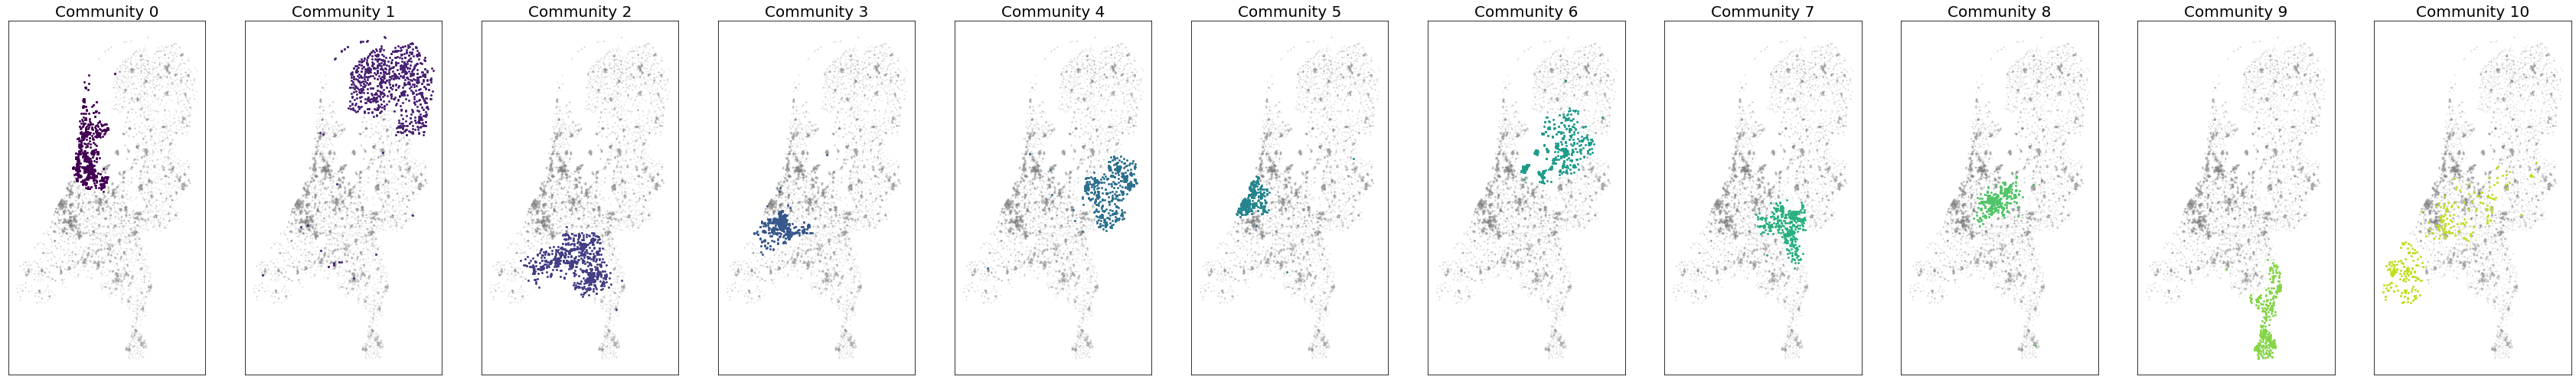

In [179]:
for consensus in [leidens[16]] :
    school_data = transnet.school_data
    NUM_COLORS = 11
    cm = plt.get_cmap('viridis')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    fig = plt.figure(figsize=[20*3,17/2.])

    for i, com in enumerate(consensus.communities): 

        ax=fig.add_subplot(1,NUM_COLORS,i+1)
        pd.DataFrame(school_data).query('BRIN not in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=2, mfc='Grey', ax=ax, alpha=0.2, mew=0)
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Community ' + str(i), fontsize=20)
        ax.legend([], frameon=False)

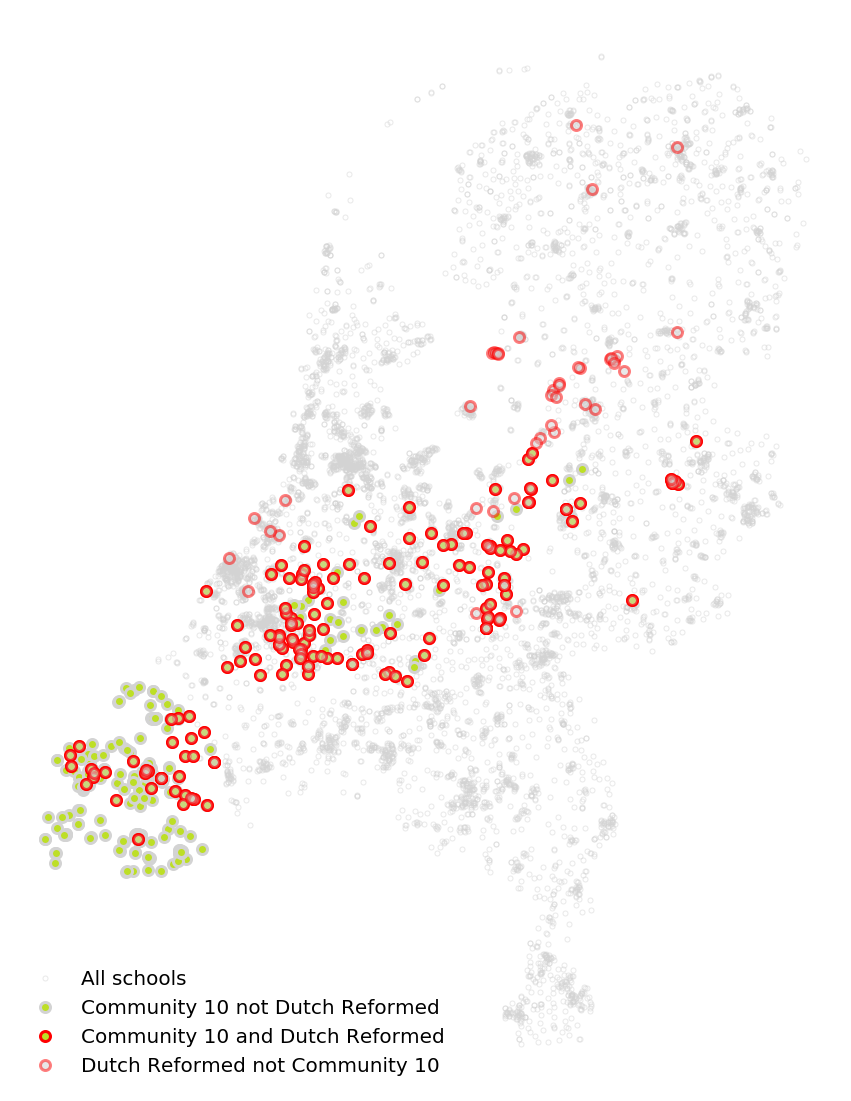

In [183]:
parts = []

for coms in leidens:
    part = dict()
    for i, com in enumerate(coms.communities):
        for n in com:
            part[n] = i
    parts.append(part)

part_frame = pd.DataFrame.from_dict(parts[16], orient='index').reset_index()
part_frame.columns = ['BRIN', 'Part']
school_data_p = transnet.school_data.merge(part_frame, on='BRIN', how='inner')


    
fig = plt.figure(figsize=[15,20])
ax=fig.add_subplot(111)


pd.DataFrame(school_data_p).query('Part != 10 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=5, mec='LightGrey', mfc='none', ax=ax, alpha=0.5)
pd.DataFrame(school_data_p).query('Part == 10 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc=cm(0.9), mec='LightGrey', mew=3., ax=ax, alpha=1.)
pd.DataFrame(school_data_p).query('Part == 10 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc=cm(0.9), mec='r', mew=3., ax=ax, alpha=1.)
pd.DataFrame(school_data_p).query('Part != 9 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc='LightGrey', mec='r', mew=3., ax=ax, alpha=0.5)



sns.despine(left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_title('', fontsize=20)
ax.legend(['All schools', 'Community 10 not Dutch Reformed','Community 10 and Dutch Reformed','Dutch Reformed not Community 10' ], fontsize=20, frameon=0)

In [184]:
com2 = leidens[16].communities[10]

In [185]:
school_data[(school_data.BRIN.isin(com2))].groupby(['provincie', 'Denomination']).count()[['BRIN']].rename(columns={'BRIN':"InCom"})

InCom
provincie     Denomination                   
Gelderland    Protestants-Christelijk       6
              Reformatorisch               42
Noord-Brabant Reformatorisch                4
Noord-Holland Reformatorisch                2
Overijssel    Reformatorisch                7
Utrecht       Protestants-Christelijk       4
              Reformatorisch               16
Zeeland       Algemeen bijzonder           19
              Antroposofisch                1
              Gereformeerd vrijgemaakt      3
              Openbaar                     79
              Overige                       1
              Protestants-Christelijk      56
              Reformatorisch               36
              Rooms-Katholiek              45
              Samenwerking PC, RK          10
Zuid-Holland  Algemeen bijzonder            1
              Protestants-Christelijk      18
              Reformatorisch               59

In [186]:
comunity_table_mm = school_data.groupby(['provincie', 'Denomination']).count()[['BRIN']].join(school_data[(school_data.BRIN.isin(com2))].groupby(['provincie', 'Denomination']).count()[['BRIN']].rename(columns={'BRIN':"InCom"})).dropna()

In [187]:
comunity_table_mm['%DenProv'] = comunity_table['InCom']/comunity_table['BRIN']*100

In [188]:
comunity_table_mm.to_csv('Consesnus_community_mm.csv')

In [189]:
comunity_table_mm

BRIN  InCom    %DenProv
provincie     Denomination                                     
Gelderland    Protestants-Christelijk    356    6.0    1.685393
              Reformatorisch              52   42.0   80.769231
Noord-Brabant Reformatorisch               4    4.0   75.000000
Noord-Holland Reformatorisch               2    2.0  100.000000
Overijssel    Reformatorisch              22    7.0   31.818182
Utrecht       Protestants-Christelijk    207    4.0    1.932367
              Reformatorisch              16   16.0  100.000000
Zeeland       Algemeen bijzonder          22   19.0   86.363636
              Antroposofisch               1    1.0  100.000000
              Gereformeerd vrijgemaakt     3    3.0  100.000000
              Openbaar                    96   79.0   82.291667
              Overige                      1    1.0  100.000000
              Protestants-Christelijk     63   56.0   88.888889
              Reformatorisch              36   36.0  100.000000
              Rooms-Katholiek             48   45.0   93.750000
              Samenwerking PC, RK         10   10.0  100.000000
Zuid-Holland  Algemeen bijzonder         169    1.0         NaN
              Protestants-Christelijk    524   18.0    2.290076
              Reformatorisch              65   59.0   90.769231

In [43]:
def mean_plus_ci(x):
    sample = x
    confidence_level = 0.95
    degrees_freedom = sample.size / 2.
    sample_mean = np.mean(sample)
    sample_standard_error = scipy.stats.sem(sample)
    
    confidence_interval = scipy.stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
    iqr = scipy.stats.iqr(sample)
    return([sample_mean, confidence_interval])

In [48]:
def sim_mat_section(devtype='Denomination', devname='Reformatorisch', ax='new fig'):
    if ax == 'new fig':
        fig = plt.figure(figsize=[8,8], dpi=300)
        ax = fig.add_subplot(111)
    fers = np.where(school_data_p.sort_values(['BRIN'])[devtype] == devname)[0]
    submat = sim_mat_all[list(np.hstack(list(fers) * len(fers))), list(np.hstack(np.transpose([list(fers)] * len(fers))))]
    ax.imshow(np.reshape(submat, (len(fers), len(fers))), cmap='viridis')
    ax.grid()
    sns.despine(ax=ax,left=True,bottom=True)
    print ('mean pairwise probability ', devname, ': ' , mean_plus_ci(np.hstack(submat)))
    return(mean_plus_ci(np.hstack(submat)))

In [47]:
import scipy
mean_plus_ci(np.hstack(sim_mat_all))

[0.10187655482041572, (0.10181558727687785, 0.10193752236395358)]

In [17]:
unique_denoms = school_data_p.Denomination.unique()
unique_denoms = np.array(unique_denoms)[list(range(10)) + [13,14,15,18,-3,-2]]

In [18]:
unique_denoms

array(['Openbaar', 'Algemeen bijzonder', 'Antroposofisch',
       'Protestants-Christelijk', 'Rooms-Katholiek',
       'Gereformeerd vrijgemaakt', 'Reformatorisch', 'Interconfessioneel',
       'Evangelisch', 'Islamitisch', 'Joods', 'Hindoe\x95stisch',
       'Evangelische broedergemeenscha', 'Gereformeerd', 'Overige',
       'Joods orthodox'], dtype=object)

In [35]:
unique_provs = school_data_p.provincie.unique()

In [37]:
unique_provs[:-1]

array(['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Groningen',
       'Limburg', 'Noord-Brabant', 'Noord-Holland', 'Overijssel',
       'Utrecht', 'Zeeland', 'Zuid-Holland'], dtype=object)

In [24]:
import seaborn as sns

mean pairwise probability  Openbaar :  0.12865196875845045
mean pairwise probability  Algemeen bijzonder :  0.1215273841119328
mean pairwise probability  Antroposofisch :  0.11763450693491845
mean pairwise probability  Protestants-Christelijk :  0.12452437228133494
mean pairwise probability  Rooms-Katholiek :  0.1471128813747816
mean pairwise probability  Gereformeerd vrijgemaakt :  0.20988384834538684
mean pairwise probability  Reformatorisch :  0.5497503698224852
mean pairwise probability  Interconfessioneel :  0.23333333333333334
mean pairwise probability  Evangelisch :  0.148828125
mean pairwise probability  Islamitisch :  0.14674586776859505
mean pairwise probability  Joods :  0.925
mean pairwise probability  Hindoestisch :  0.28
mean pairwise probability  Evangelische broedergemeenscha :  0.5
mean pairwise probability  Gereformeerd :  0.2682098765432099
mean pairwise probability  Overige :  0.3333333333333333
mean pairwise probability  Joods orthodox :  1.0


//miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
//miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0, flags=flags)


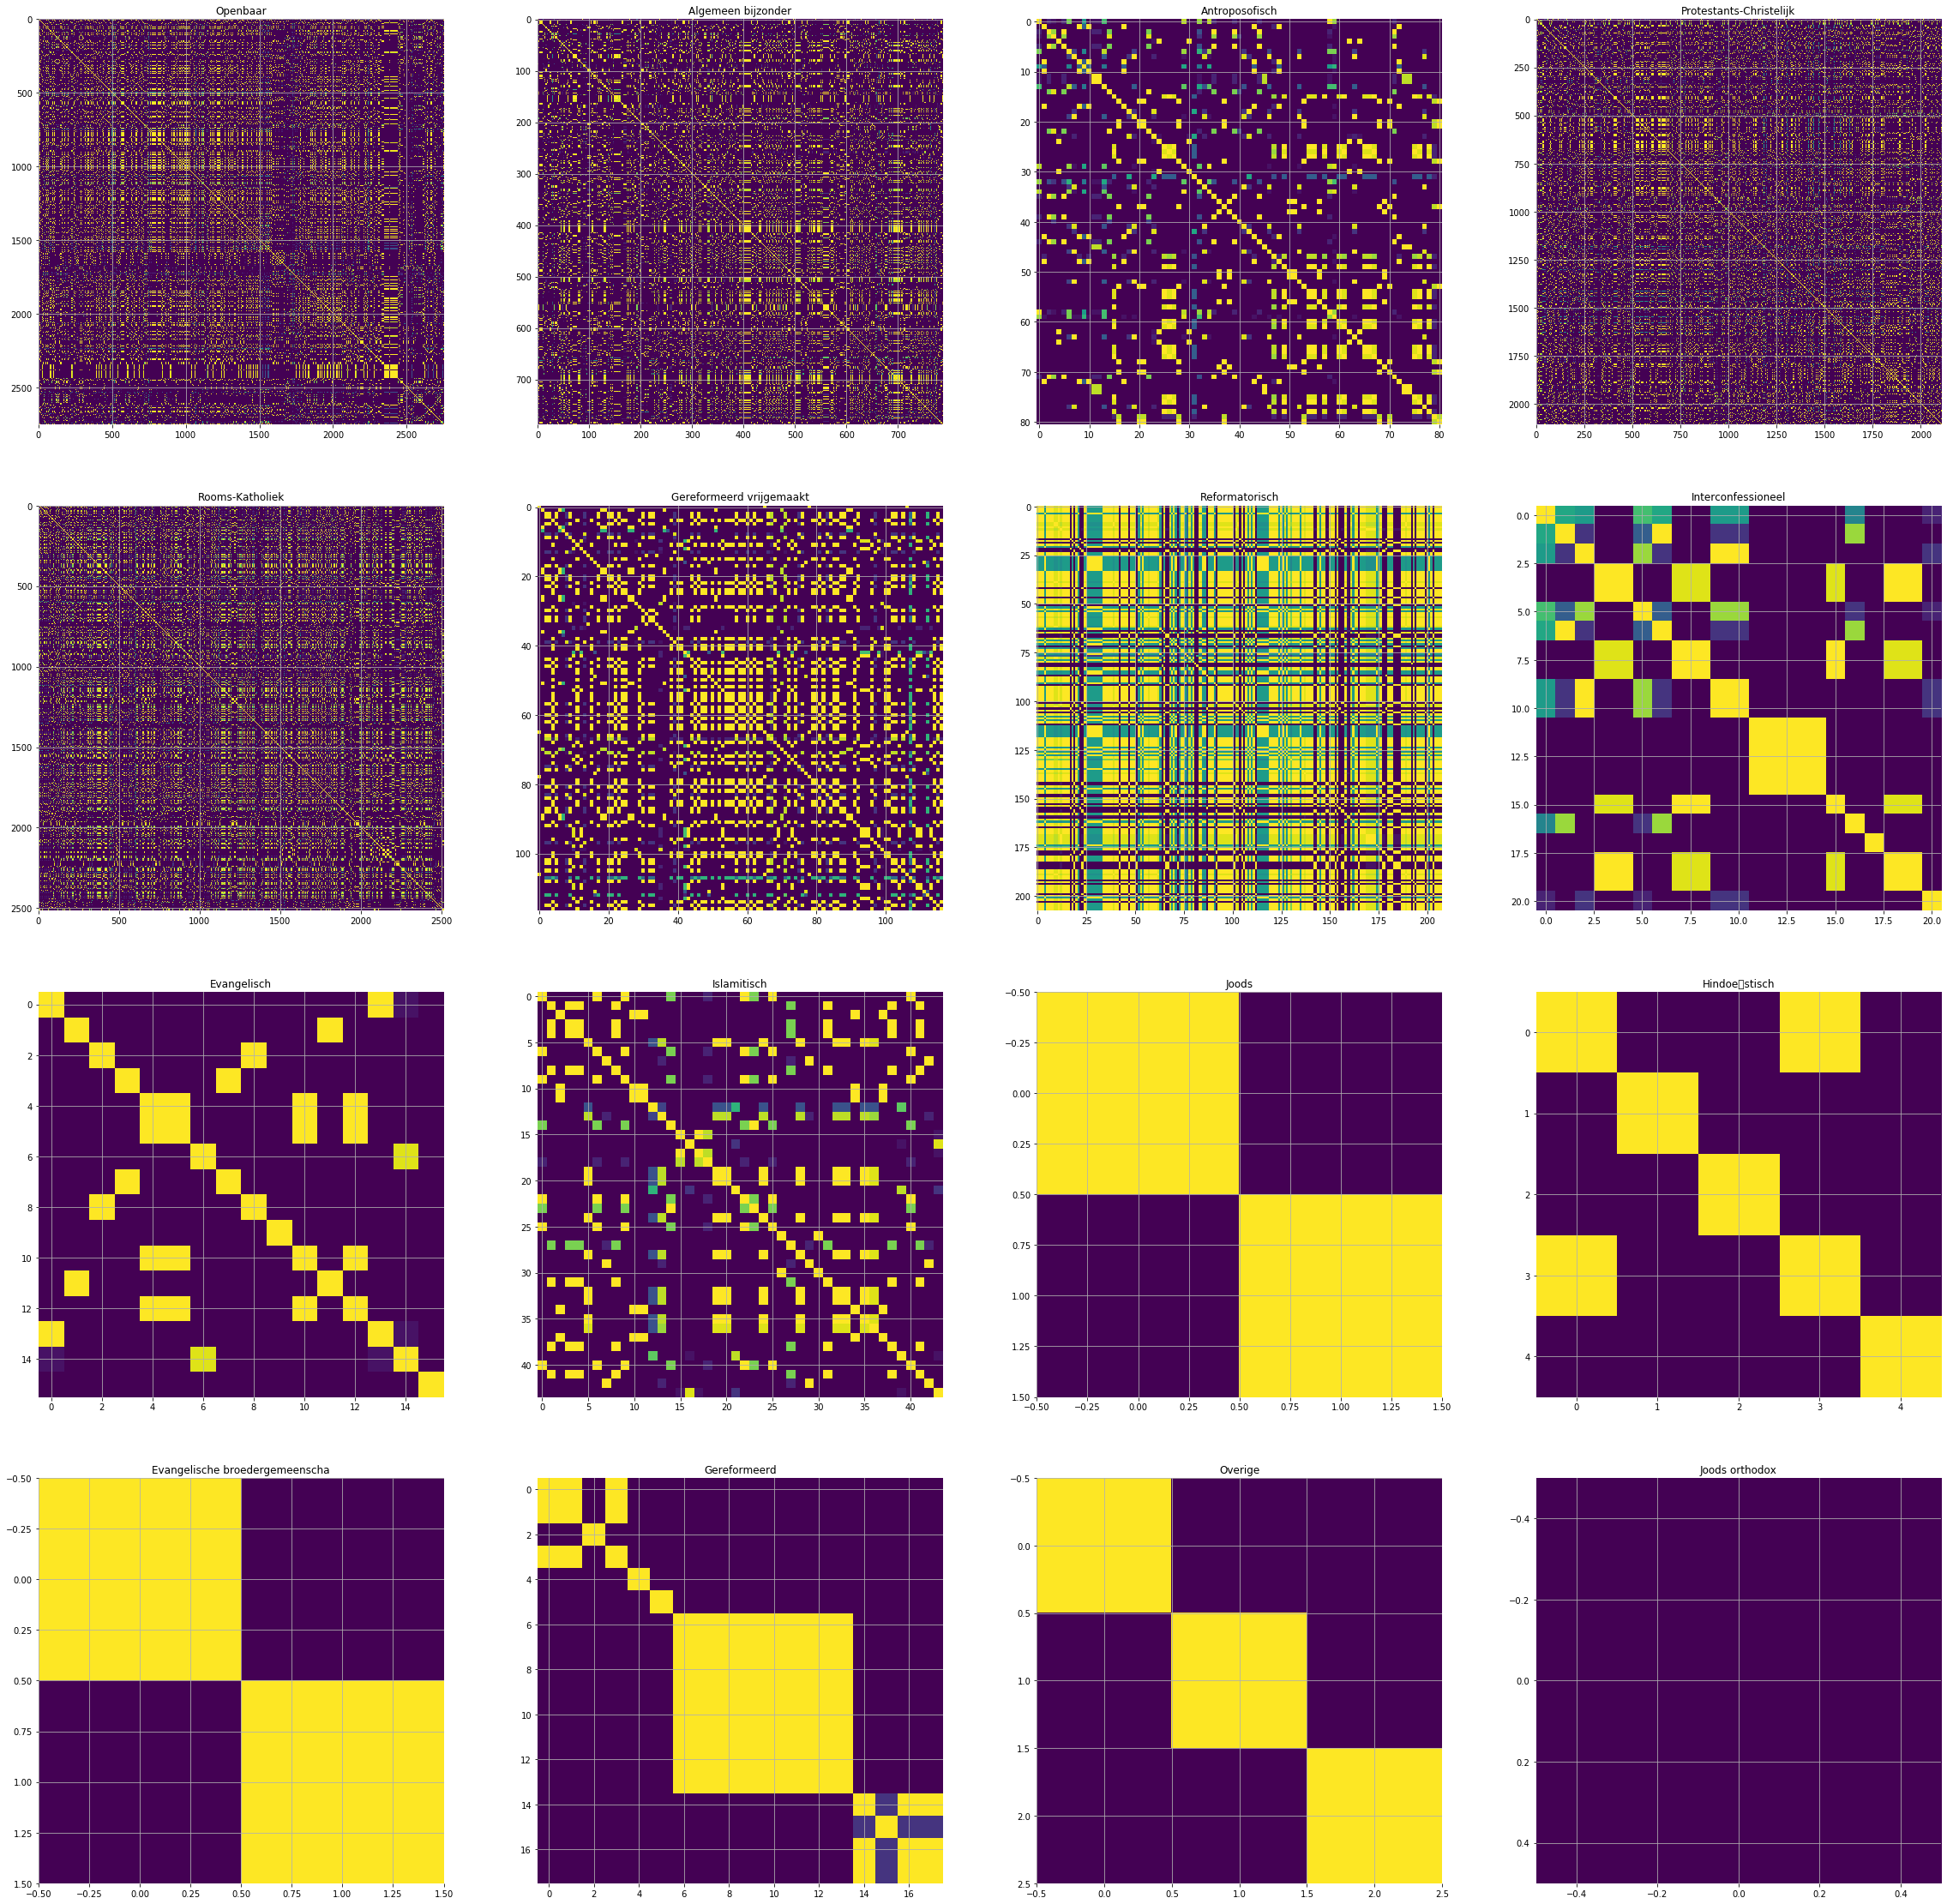

In [25]:
mwp = []
fig=plt.figure(figsize=[40,40])
for i, denominiation in enumerate(unique_denoms):
    ax = fig.add_subplot(4, 4, i +1)
    mwp_i = sim_mat_section('Denomination', denominiation, ax)
    mwp.append([denominiation, mwp_i])
    try:
        ax.set_title(denominiation)
    except:
        ax.set_title('Hindu')

mean pairwise probability  Openbaar :  [0.12865196875845045, (0.1284231620296098, 0.1288807754872911)]
mean pairwise probability  Algemeen bijzonder :  [0.1215273841119328, (0.12074588336842464, 0.12230888485544096)]
mean pairwise probability  Antroposofisch :  [0.11763450693491845, (0.11024069661061475, 0.12502831725922214)]
mean pairwise probability  Protestants-Christelijk :  [0.12452437228133494, (0.1242314126366295, 0.12481733192604037)]
mean pairwise probability  Rooms-Katholiek :  [0.1471128813747816, (0.14685622027354192, 0.14736954247602127)]
mean pairwise probability  Gereformeerd vrijgemaakt :  [0.20988384834538684, (0.20325827634216936, 0.21650942034860432)]
mean pairwise probability  Reformatorisch :  [0.5497503698224852, (0.5457203798954138, 0.5537803597495565)]
mean pairwise probability  Interconfessioneel :  [0.23333333333333334, (0.19607161303805581, 0.27059505362861086)]
mean pairwise probability  Evangelisch :  [0.148828125, (0.10492071467873243, 0.19273553532126758)

//miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
//miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
//miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
//miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0, flags=flags)


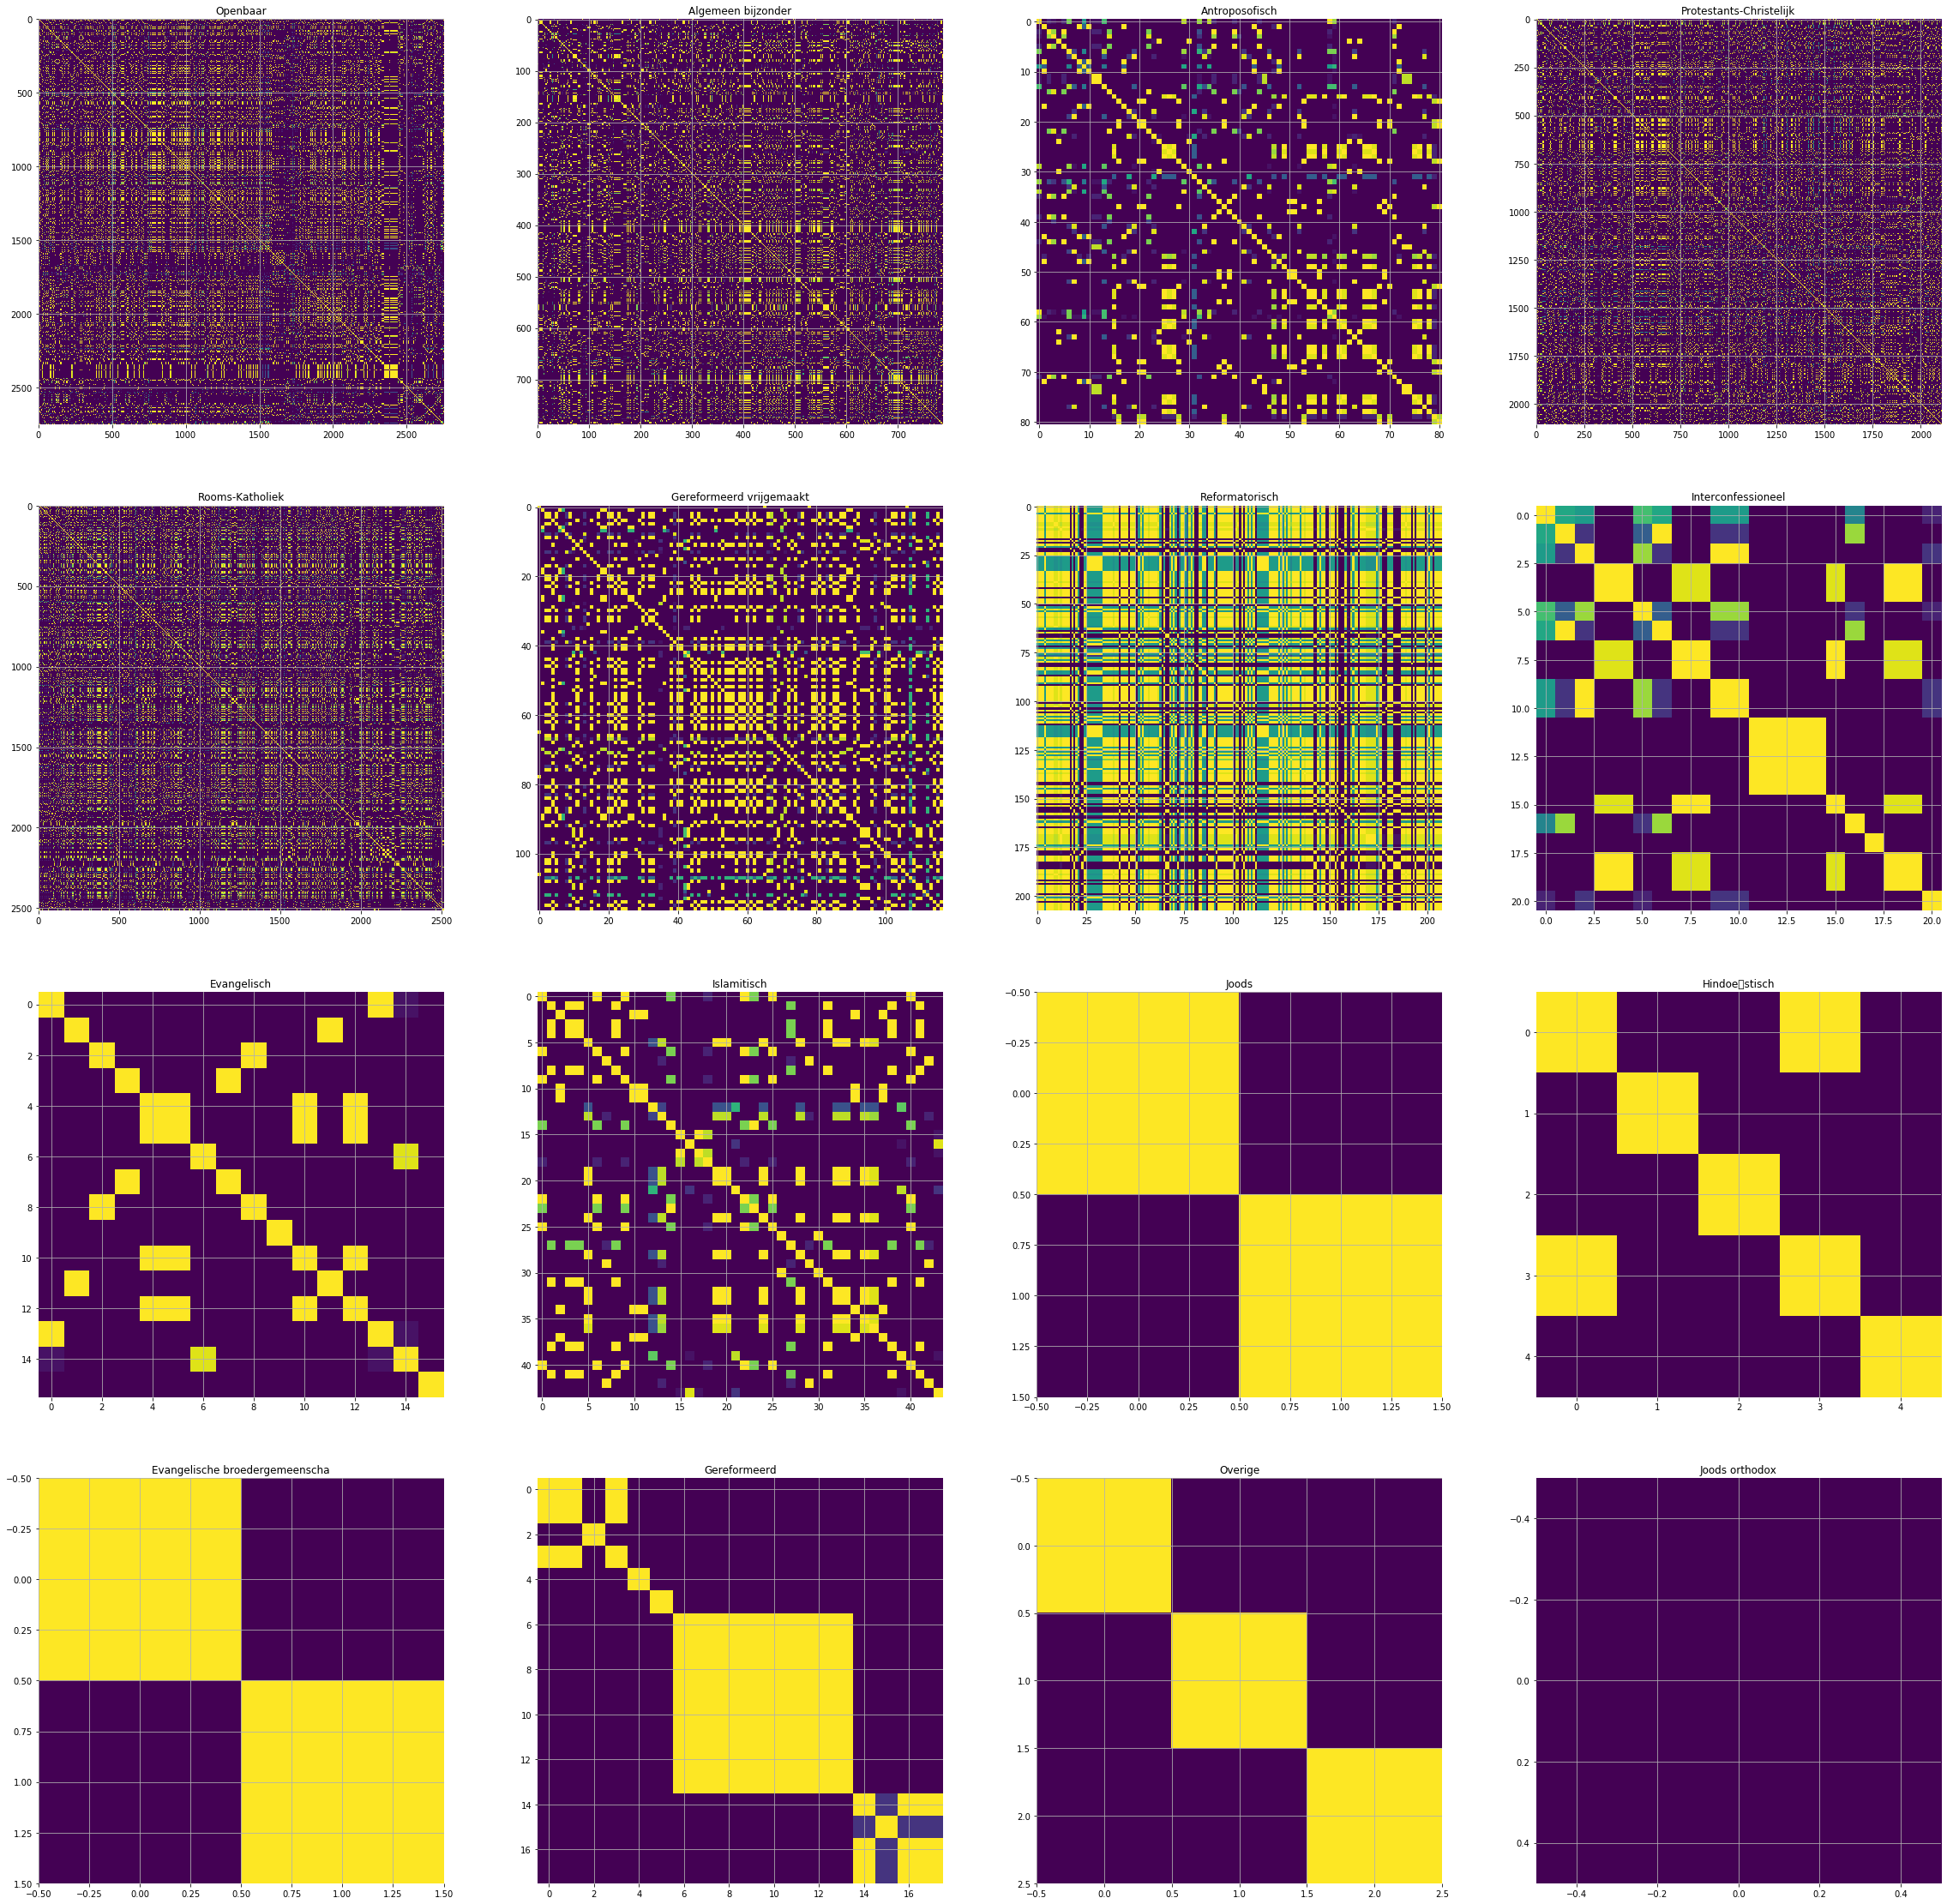

In [49]:
mwp = []
fig=plt.figure(figsize=[40,40])
for i, denominiation in enumerate(unique_denoms):
    ax = fig.add_subplot(4, 4, i +1)
    mwp_i = sim_mat_section('Denomination', denominiation, ax)
    mwp.append([denominiation, mwp_i])
    try:
        ax.set_title(denominiation)
    except:
        ax.set_title('Hindu')

In [50]:
mwp_df = pd.DataFrame(mwp)
mwp_df.columns = ["Denomination", "Mean Pairwise Probabability"]
mwp_df.sort_values('Mean Pairwise Probabability', ascending=False)

Denomination  \
15                  Joods orthodox   
10                           Joods   
6                   Reformatorisch   
12  Evangelische broedergemeenscha   
14                         Overige   
11                   Hindoestisch   
13                    Gereformeerd   
7               Interconfessioneel   
5         Gereformeerd vrijgemaakt   
8                      Evangelisch   
4                  Rooms-Katholiek   
9                      Islamitisch   
0                         Openbaar   
3          Protestants-Christelijk   
1               Algemeen bijzonder   
2                   Antroposofisch   

                          Mean Pairwise Probabability  
15                                  [1.0, (nan, nan)]  
10  [0.925, (0.7386896716117186, 1.1113103283882815)]  
6   [0.5497503698224852, (0.5457203798954138, 0.55...  
12   [0.5, (-0.7420688559218762, 1.7420688559218762)]  
14  [0.3333333333333333, (-0.10981872453406721, 0....  
11  [0.28, (0.08119082442194975, 0.4788091755780503)]  
13  [0.2682098765432099, (0.21982541253067253, 0.3...  
7   [0.23333333333333334, (0.19607161303805581, 0....  
5   [0.20988384834538684, (0.20325827634216936, 0....  
8   [0.148828125, (0.10492071467873243, 0.19273553...  
4   [0.1471128813747816, (0.14685622027354192, 0.1...  
9   [0.14674586776859505, (0.13151481542219476, 0....  
0   [0.12865196875845045, (0.1284231620296098, 0.1...  
3   [0.12452437228133494, (0.1242314126366295, 0.1...  
1   [0.1215273841119328, (0.12074588336842464, 0.1...  
2   [0.11763450693491845, (0.11024069661061475, 0....

In [52]:
mwp_df.to_csv('mpw.csv')

mean pairwise probability  Drenthe :  [0.755393586005831, (0.7530577738020345, 0.7577293982096274)]
mean pairwise probability  Flevoland :  [0.6840127109357879, (0.681899416936147, 0.6861260049354287)]
mean pairwise probability  Friesland :  [0.9884607780612245, (0.9881343683430925, 0.9887871877793564)]
mean pairwise probability  Gelderland :  [0.34304628470935133, (0.3423803148426997, 0.34371225457600296)]
mean pairwise probability  Groningen :  [0.9959805594858163, (0.9957478634570187, 0.9962132555146139)]
mean pairwise probability  Limburg :  [0.8565139859734987, (0.855465026339588, 0.8575629456074094)]
mean pairwise probability  Noord-Brabant :  [0.7842376092273301, (0.7837127997343822, 0.784762418720278)]
mean pairwise probability  Noord-Holland :  [0.9495784996521512, (0.949391805674594, 0.9497651936297085)]
mean pairwise probability  Overijssel :  [0.5455954930992004, (0.544418913888971, 0.5467720723094298)]
mean pairwise probability  Utrecht :  [0.7235283663487144, (0.722161602

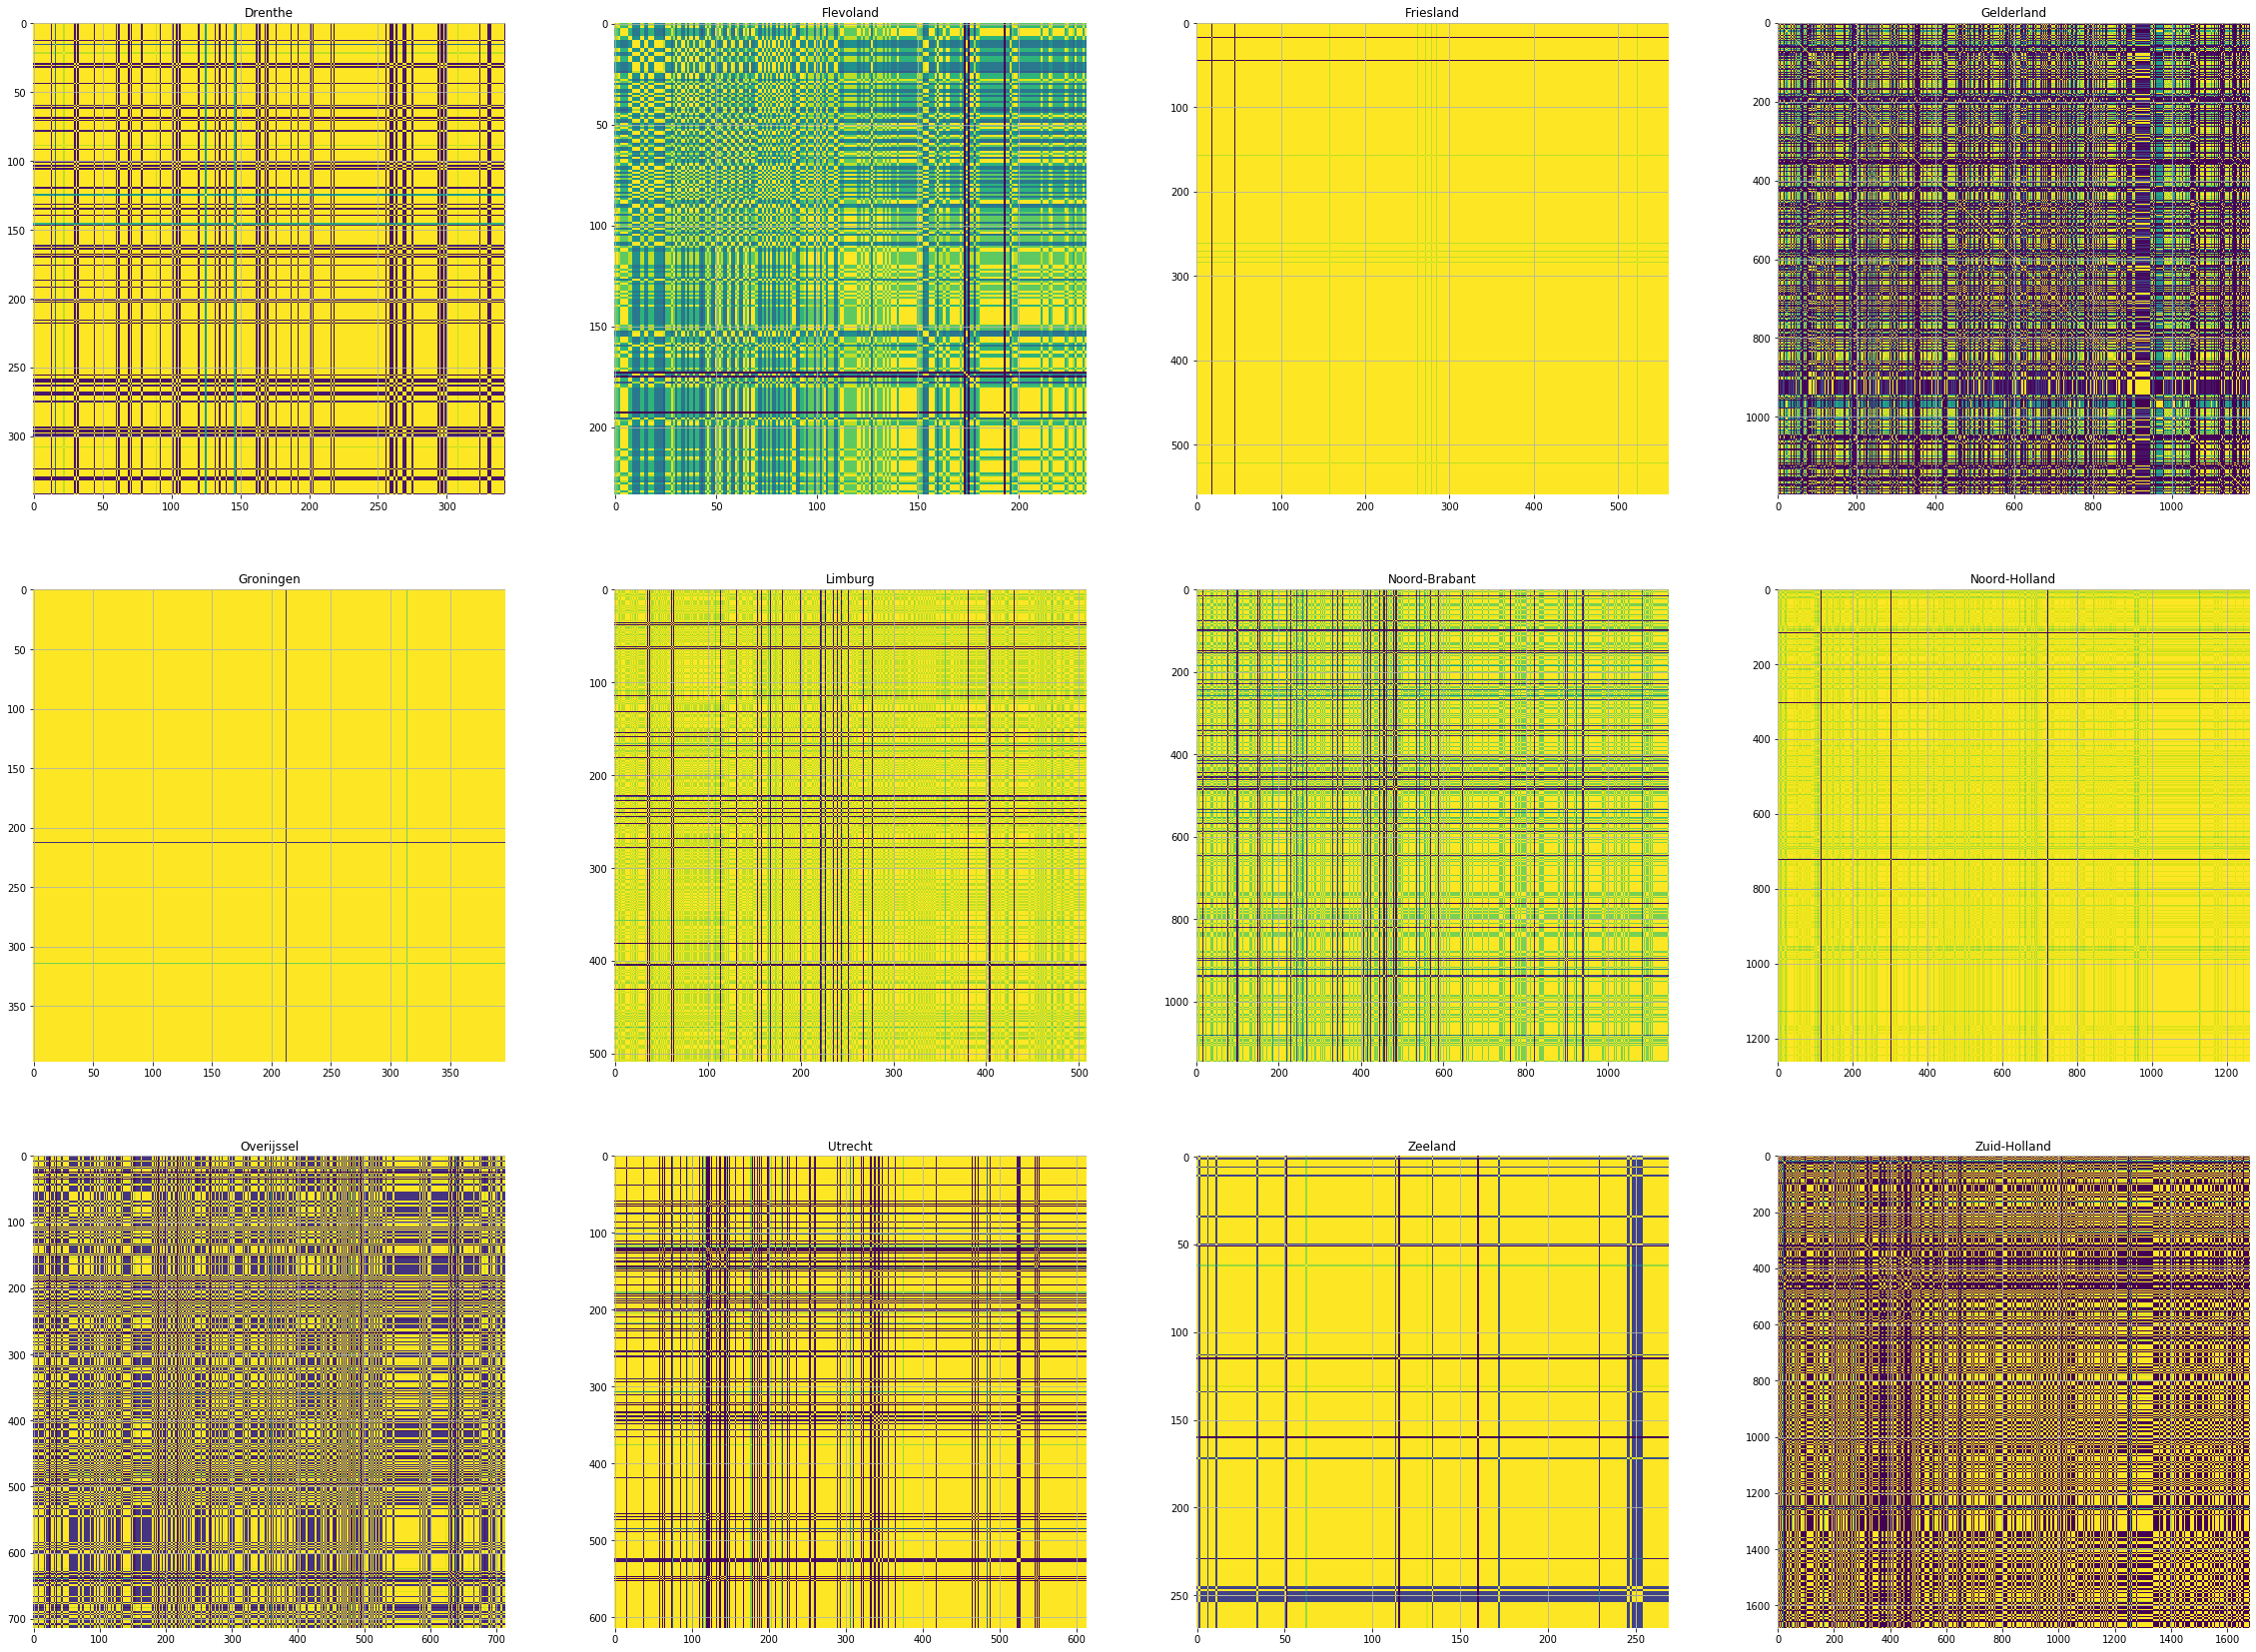

In [53]:
mwp_prov = []
fig=plt.figure(figsize=[40,40])
for i, denominiation in enumerate(unique_provs[:-1]):
    ax = fig.add_subplot(4, 4, i +1)
    mwp_i = sim_mat_section('provincie', denominiation, ax)
    mwp_prov.append([denominiation, mwp_i])
    try:
        ax.set_title(denominiation)
    except:
        ax.set_title('Hindu')

In [54]:
mwp_df = pd.DataFrame(mwp_prov)
mwp_df.columns = ["Denomination", "Mean Pairwise Probabability"]
mwp_df.sort_values('Mean Pairwise Probabability', ascending=False)

Denomination                        Mean Pairwise Probabability
4       Groningen  [0.9959805594858163, (0.9957478634570187, 0.99...
2       Friesland  [0.9884607780612245, (0.9881343683430925, 0.98...
7   Noord-Holland  [0.9495784996521512, (0.949391805674594, 0.949...
10        Zeeland  [0.8871919956882852, (0.8851102617188357, 0.88...
5         Limburg  [0.8565139859734987, (0.855465026339588, 0.857...
6   Noord-Brabant  [0.7842376092273301, (0.7837127997343822, 0.78...
0         Drenthe  [0.755393586005831, (0.7530577738020345, 0.757...
9         Utrecht  [0.7235283663487144, (0.7221616028261094, 0.72...
1       Flevoland  [0.6840127109357879, (0.681899416936147, 0.686...
8      Overijssel  [0.5455954930992004, (0.544418913888971, 0.546...
11   Zuid-Holland  [0.4415786210317457, (0.4410066837051338, 0.44...
3      Gelderland  [0.34304628470935133, (0.3423803148426997, 0.3...

In [249]:
school_data[(school_data.BRIN.isin(com))].groupby(['provincie']).count()[["BRIN"]]

BRIN
provincie          
Gelderland       48
Noord-Brabant     4
Noord-Holland     1
Overijssel        7
Utrecht          20
Zeeland         250
Zuid-Holland     75

(8926, 8926)

In [138]:
np.unique(np.array(sim_mat_cons_2))

array([0., 1.])

In [132]:
len(np.where(np.array(sim_mat_cons) == 0.2)[0])

964512

In [133]:
len(np.where(np.array(sim_mat_cons) > 0)[0])

9996606

In [ ]:
STOP = True

while STOP == False:
    sim_mat = calc_sim_mat(leidens)
    sim_net = transnet.create_network_from_transmat(sim_mat, np.array(school_data_p.sort_values(['BRIN']).BRIN))
    consensuses = [algorithms.leiden(sim_net, weights='weight') for x in range(10)]

In [108]:
coms = []

for i, com in enumerate(parts):
    
    part_frame = pd.DataFrame.from_dict(parts[i], orient='index').reset_index()
    part_frame.columns = ['BRIN', 'Part']
    school_data_p = transnet.school_data.merge(part_frame, on='BRIN', how='inner')
    coms.append(list(school_data_p.sort_values('BRIN').Part))

In [109]:
summed_mats = np.zeros([len(coms[0]), len(coms[0])]) 

for i, com in enumerate(coms):
    print ('Set ', i)
    summed_mats = summed_mats + np.array([list(np.array(com) == com[n]) for n in range(len(com))])

Set  0
Set  1
Set  2
Set  3
Set  4
Set  5
Set  6
Set  7
Set  8
Set  9


In [110]:
sim_mat = summed_mats/10.

In [113]:
consensus_coms = algorithms.leiden(sim_net, weights='weight')

In [102]:
school_data_p.sort_values(['provincie','xy']).BRIN

115     05RN00
212     18PE00
113     04VK00
158     04HW00
8017    03XM00
         ...  
5972    06KD00
8397    17XU00
6392    10CU00
6073    11RJ00
6115    05TB00
Name: BRIN, Length: 8926, dtype: object

In [105]:
len(school_data_p.sort_values(['provincie','xy']).BRIN)

8926

In [348]:
np.unique(sim_mat)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [139]:
consensuses_2[0]

In [161]:
significance_consensus = evaluation.significance(transnet.data_net,consensuses_2[0], summary=False)
ied_consensus = evaluation.internal_edge_density(transnet.data_net,consensuses_2[0], summary=False)
ng_modularity_consensus = evaluation.newman_girvan_modularity(transnet.data_net,consensuses_2[0], summary=False)
modularity_density_consensus = evaluation.modularity_density(transnet.data_net,consensuses_2[0], summary=False)
surprise_consensus = evaluation.surprise(transnet.data_net,consensuses_2[0], summary=False)

In [315]:
evaluation.nf1(consensuses[4], consensuses_2[1])

MatchingResult(score=0.8397, std=None)

In [162]:
significance_consensus

FitnessResult(min=None, max=None, score=849758.555203784, std=None)

In [163]:
ied_consensus

[0.005059481262126009,
 0.006062103594080338,
 0.004314648814251674,
 0.004071467299048893,
 0.00658490082120718,
 0.009949809877921613,
 0.011311958179659787,
 0.011195194258074583,
 0.007758088689059332]

In [306]:
ng_modularity_consensus

FitnessResult(min=None, max=None, score=0.01826880370483168, std=None)

In [307]:
modularity_density_consensus

FitnessResult(min=None, max=None, score=0.12065537964750066, std=None)

In [166]:
surprise_consensus

FitnessResult(min=None, max=None, score=86578.85182579009, std=None)

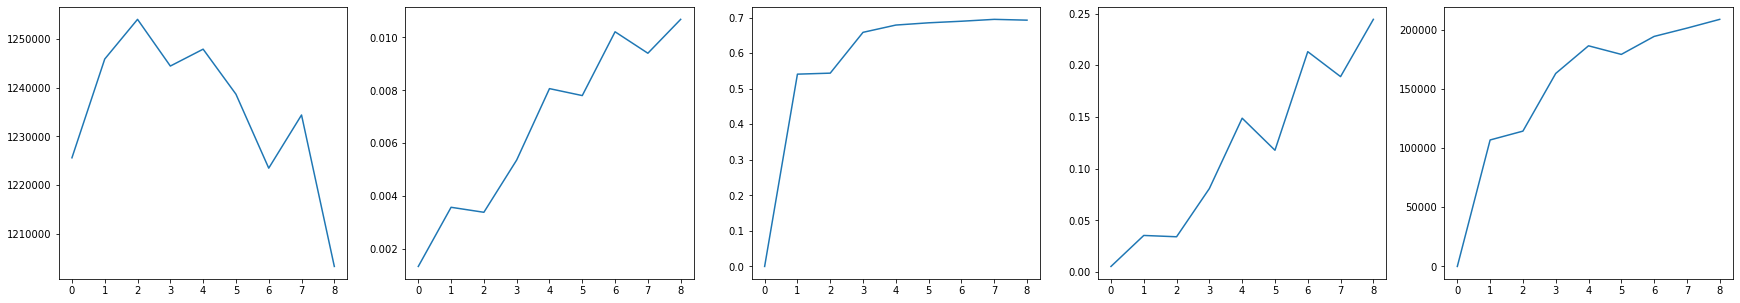

In [322]:
fig = plt.figure(figsize = [30,5])
ax = fig.add_subplot(151)
plt.plot(significance)
ax = fig.add_subplot(152)
plt.plot(ied)
ax = fig.add_subplot(153)
plt.plot(ng_modularity)
ax = fig.add_subplot(154)
plt.plot(modularity_density)
ax = fig.add_subplot(155)
plt.plot(surprise)

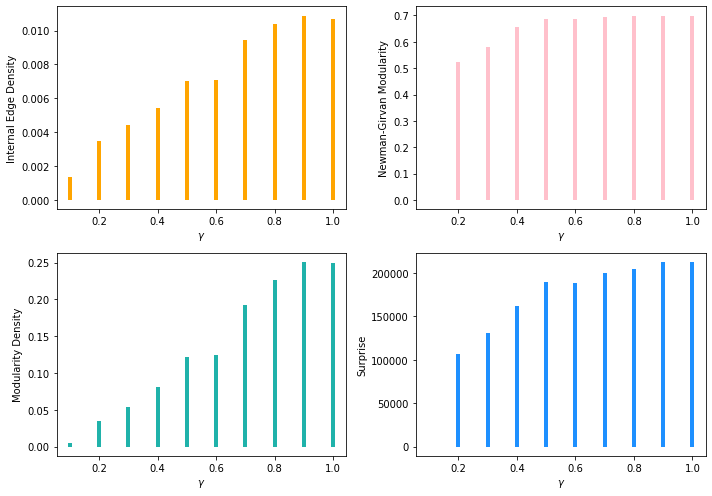

In [278]:
fig = plt.figure(figsize = [10,7])
ax = fig.add_subplot(221)
plt.vlines(ymin=0, ymax=ied, x=np.arange(0.1,1.1,0.1), lw=4, color='Orange')
plt.ylabel('Internal Edge Density')
plt.xlabel('$\gamma$')

ax = fig.add_subplot(222)
plt.vlines(ymin=0, ymax=ng_modularity, x=np.arange(0.1,1.1,0.1), lw=4, color='Pink')
plt.ylabel('Newman-Girvan Modularity')
plt.xlabel('$\gamma$')
ax = fig.add_subplot(223)
plt.vlines(ymin=0, ymax=modularity_density, x=np.arange(0.1,1.1,0.1), lw=4, color='LightSeaGreen')
plt.ylabel('Modularity Density')
plt.xlabel('$\gamma$')
ax = fig.add_subplot(224)
plt.vlines(ymin=0, ymax=surprise, x=np.arange(0.1,1.1,0.1), lw=4, color='DodgerBlue')
plt.ylabel('Surprise')
plt.xlabel('$\gamma$')
plt.tight_layout()

In [264]:
communities[-1].method_parameters

{'initial_membership': None, 'weights': 'weight', 'resolution_parameter': 0.9}

In [186]:
row=[]
for i in range(10):
    row.append(consensuses_2[0].normalized_mutual_information(consensuses[i]).score)

In [187]:
row

[0.9753471781575298,
 1.0,
 0.9753471781575298,
 0.9753471781575298,
 0.9753471781575298,
 0.9753471781575298,
 0.9753471781575298,
 0.974638272505388,
 0.9753471781575298,
 1.0]

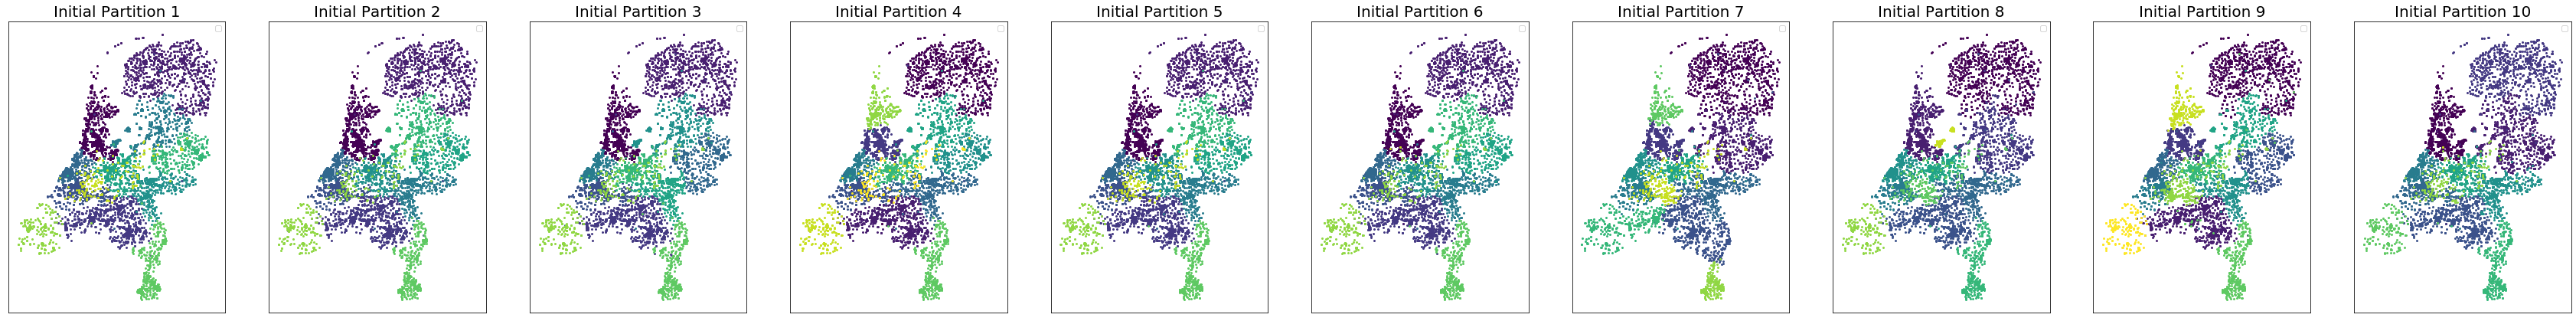

In [339]:
fig = plt.figure(figsize=[20*3,7])

for j , consensus in enumerate(leidens):
    school_data = transnet.school_data
    NUM_COLORS = 12
    cm = plt.get_cmap('viridis')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    ax=fig.add_subplot(1,10,j+1)

    for i, com in enumerate(consensus.communities): 

        
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Initial Partition ' + str(j + 1), fontsize=20)
        ax.legend([])

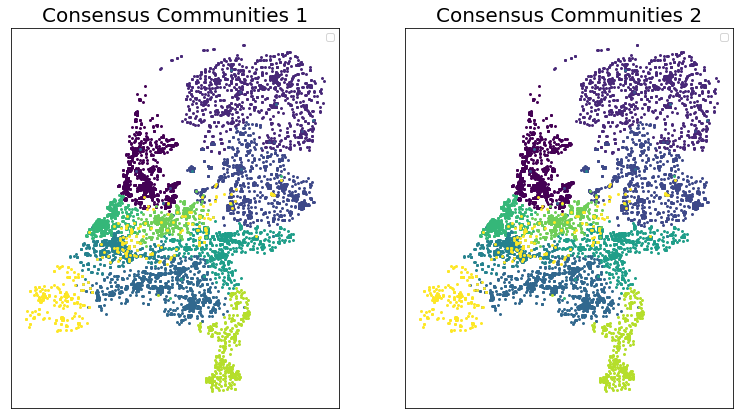

In [61]:
fig = plt.figure(figsize=[20,7])

for j , consensus in enumerate([consensuses_all[1],consensuses_all[5]]):
    school_data = transnet.school_data
    NUM_COLORS = 9
    cm = plt.get_cmap('viridis')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    ax=fig.add_subplot(1,3,j+1)

    for i, com in enumerate(consensus.communities): 

        
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Consensus Communities ' + str(j + 1), fontsize=20)
        ax.legend([])

In [218]:
significance_cons = [evaluation.significance(transnet.data_net,community).score for community in [consensuses[0],consensuses[1], consensuses[7]]]
ied_cons = [evaluation.internal_edge_density(transnet.data_net,community).score for community in [consensuses[0],consensuses[1], consensuses[7]]]
ng_modularity_cons = [evaluation.newman_girvan_modularity(transnet.data_net,community).score for community in [consensuses[0],consensuses[1], consensuses[7]]]
modularity_density_cons = [evaluation.modularity_density(transnet.data_net,community).score for community in [consensuses[0],consensuses[1], consensuses[7]]]
surprise_cons = [evaluation.surprise(transnet.data_net,community).score for community in [consensuses[0],consensuses[1], consensuses[7]]]

In [222]:
surprise_cons

[95101.48110215353, 86578.85182579009, 95090.09006104538]

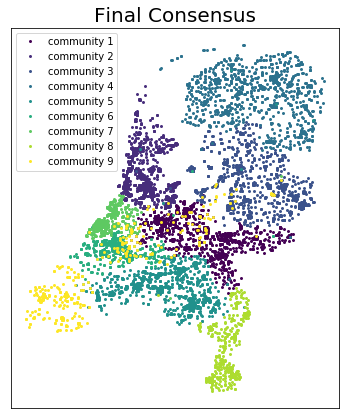

In [319]:
fig = plt.figure(figsize=[20,7])

for j , consensus in enumerate([consensuses_2[0]]):
    school_data = transnet.school_data
    NUM_COLORS = 8
    cm = plt.get_cmap('viridis')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    ax=fig.add_subplot(1,3,j+1)

    for i, com in enumerate(consensus.communities): 

        
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                alpha=1., mew=0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_title('Final Consensus', fontsize=20)
    ax.legend(['community ' + str(c+1) for c in range(i+1)])

In [659]:
com3 = mp_compss[0].communities[1]
school_data[(school_data.BRIN.isin(com3))].groupby(['provincie', 'Denomination']).count()[['BRIN']]

BRIN
provincie    Denomination                        
Drenthe      Protestants-Christelijk            1
Flevoland    Algemeen bijzonder                 1
Friesland    Openbaar                           1
Gelderland   Algemeen bijzonder                 3
             Openbaar                          15
...                                           ...
Zuid-Holland Rooms-Katholiek                  100
             Samenwerking Opb., RK              1
             Samenwerking PC, Alg. Bijz.        1
             Samenwerking PC, RK                1
             Samenwerking PC, RK, Alg. Bijz    21

[63 rows x 1 columns]

In [298]:
school_data.merge(part_frame, on='BRIN')

BRIN     pc6     provincie  leerlingen        Denomination  x_coord  \
0     16AH00  7822HG       Drenthe       228.0            Openbaar   257488   
1     16BX00  7811LD       Drenthe        70.0            Openbaar   256919   
2     16DJ00  7814RC       Drenthe       113.0            Openbaar   258145   
3     16HI00  7815LB       Drenthe        96.0            Openbaar   256841   
4     16MA00  7824HK       Drenthe       372.0            Openbaar   259240   
...      ...     ...           ...         ...                 ...      ...   
8921  30PP00  9932BD     Groningen       864.0  Algemeen bijzonder   254929   
8922  30PP01  9628AL     Groningen       151.0  Algemeen bijzonder   254050   
8923  30PP02  9902RB     Groningen       107.0  Algemeen bijzonder   254300   
8924  30PP04  9901CE     Groningen      1099.0  Algemeen bijzonder   253805   
8925  20BH02  2903GM  Zuid-Holland       161.0  Algemeen bijzonder   100101   

      y_coord kind                       geometry                xy  Part  
0      534033  pri  POINT (257488.000 534033.000)  (257488, 534033)     2  
1      533182  pri  POINT (256919.000 533182.000)  (256919, 533182)     2  
2      537834  pri  POINT (258145.000 537834.000)  (258145, 537834)     2  
3      535627  pri  POINT (256841.000 535627.000)  (256841, 535627)     2  
4      533798  pri  POINT (259240.000 533798.000)  (259240, 533798)     2  
...       ...  ...                            ...               ...   ...  
8921   594002  sec  POINT (254929.000 594002.000)  (254929, 594002)     2  
8922   585677  sec  POINT (254050.000 585677.000)  (254050, 585677)     2  
8923   593197  sec  POINT (254300.000 593197.000)  (254300, 593197)     2  
8924   594195  sec  POINT (253805.000 594195.000)  (253805, 594195)     2  
8925   438744  sec  POINT (100101.000 438744.000)  (100101, 438744)     4  

[8926 rows x 11 columns]

In [300]:
parts = []
for coms in consensuses_2:
    part = dict()
    for i, com in enumerate(coms.communities):
        for n in com:
            part[n] = i
    parts.append(part)

In [302]:
part_frame = pd.DataFrame.from_dict(parts[0], orient='index').reset_index()
part_frame.columns = ['BRIN', 'Part']
school_data_p = transnet.school_data.merge(part_frame, on='BRIN', how='inner')

In [303]:
school_data_p

BRIN     pc6     provincie  leerlingen        Denomination  x_coord  \
0     16AH00  7822HG       Drenthe       228.0            Openbaar   257488   
1     16BX00  7811LD       Drenthe        70.0            Openbaar   256919   
2     16DJ00  7814RC       Drenthe       113.0            Openbaar   258145   
3     16HI00  7815LB       Drenthe        96.0            Openbaar   256841   
4     16MA00  7824HK       Drenthe       372.0            Openbaar   259240   
...      ...     ...           ...         ...                 ...      ...   
8921  30PP00  9932BD     Groningen       864.0  Algemeen bijzonder   254929   
8922  30PP01  9628AL     Groningen       151.0  Algemeen bijzonder   254050   
8923  30PP02  9902RB     Groningen       107.0  Algemeen bijzonder   254300   
8924  30PP04  9901CE     Groningen      1099.0  Algemeen bijzonder   253805   
8925  20BH02  2903GM  Zuid-Holland       161.0  Algemeen bijzonder   100101   

      y_coord kind                       geometry                xy  Part  
0      534033  pri  POINT (257488.000 534033.000)  (257488, 534033)     3  
1      533182  pri  POINT (256919.000 533182.000)  (256919, 533182)     3  
2      537834  pri  POINT (258145.000 537834.000)  (258145, 537834)     3  
3      535627  pri  POINT (256841.000 535627.000)  (256841, 535627)     3  
4      533798  pri  POINT (259240.000 533798.000)  (259240, 533798)     3  
...       ...  ...                            ...               ...   ...  
8921   594002  sec  POINT (254929.000 594002.000)  (254929, 594002)     3  
8922   585677  sec  POINT (254050.000 585677.000)  (254050, 585677)     3  
8923   593197  sec  POINT (254300.000 593197.000)  (254300, 593197)     3  
8924   594195  sec  POINT (253805.000 594195.000)  (253805, 594195)     3  
8925   438744  sec  POINT (100101.000 438744.000)  (100101, 438744)     5  

[8926 rows x 11 columns]

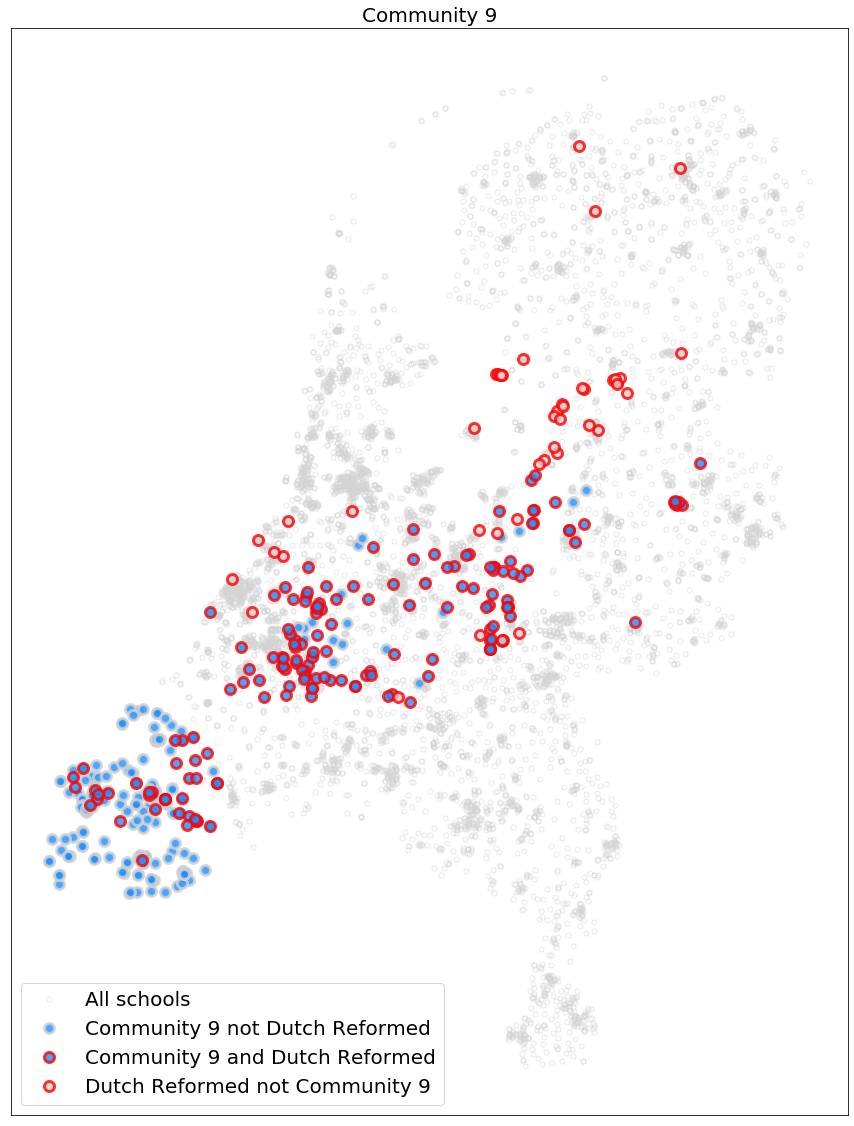

In [320]:
fig = plt.figure(figsize=[15,20])
ax=fig.add_subplot(111)


pd.DataFrame(school_data_p).query('Part != 8 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=5, mec='LightGrey', mfc='none', ax=ax, alpha=0.5)
pd.DataFrame(school_data_p).query('Part == 8 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc='DodgerBlue', mec='LightGrey', mew=3., ax=ax, alpha=0.8)
pd.DataFrame(school_data_p).query('Part == 8 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc='DodgerBlue', mec='r', mew=3., ax=ax, alpha=0.8)
pd.DataFrame(school_data_p).query('Part != 8 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc='LightGrey', mec='r', mew=3., ax=ax, alpha=0.8)




ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_title('Community 9', fontsize=20)
ax.legend(['All schools', 'Community 9 not Dutch Reformed','Community 9 and Dutch Reformed','Dutch Reformed not Community 9' ], fontsize=20)

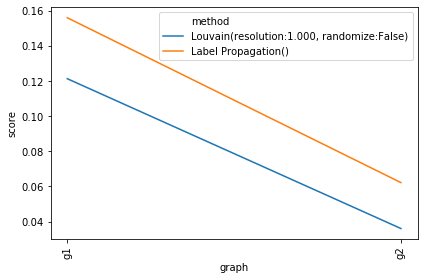

In [326]:
import cdlib
from cdlib import viz
references =[]
g1 = nx.algorithms.community.LFR_benchmark_graph(1000, 3, 1.5, 0.5, min_community=20, average_degree=5)
g2 = nx.algorithms.community.LFR_benchmark_graph(1000, 3, 1.5, 0.7, min_community=20, average_degree=5)
names = ["g1", "g2"]
graphs = [g1, g2]
for g in graphs:
    references.append(cdlib.NodeClustering(communities={frozenset(g.nodes[v]['community']) for v in g}, graph=g, method_name="reference"))
algos = [algorithms.crisp_partition.louvain, algorithms.crisp_partition.label_propagation]
viz.plot_scoring(graphs, references, names, algos, nbRuns=2)

In [329]:
im_coms

In [170]:
significance = [evaluation.significance(transnet.data_net,community).score for community in leidens]
ied = [evaluation.internal_edge_density(transnet.data_net,community).score for community in leidens]
ng_modularity = [evaluation.newman_girvan_modularity(transnet.data_net,community).score for community in leidens]
modularity_density = [evaluation.modularity_density(transnet.data_net,community).score for community in leidens]
surprise = [evaluation.surprise(transnet.data_net,community).score for community in leidens]

//miniconda3/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:811: RuntimeWarning: divide by zero encountered in log
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))
//miniconda3/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:811: RuntimeWarning: invalid value encountered in double_scalars
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))


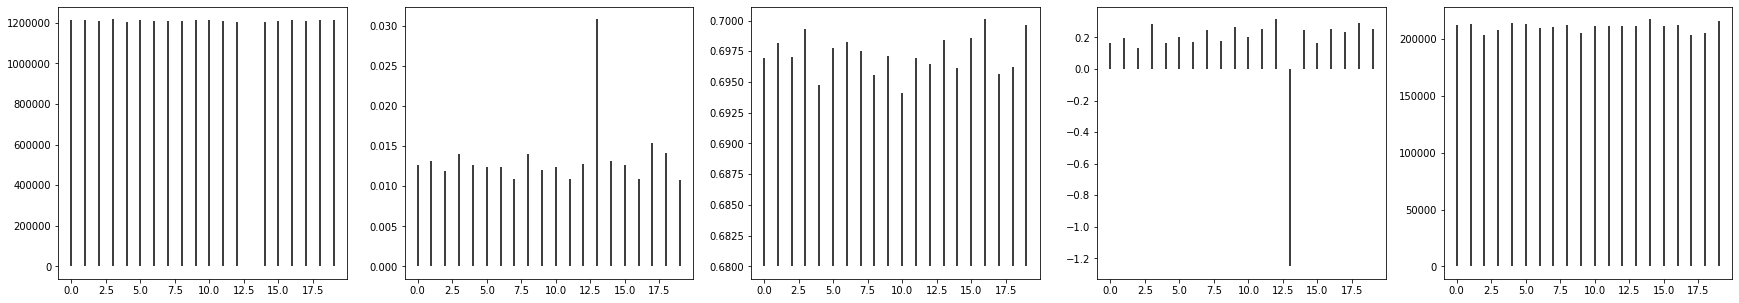

In [176]:
fig = plt.figure(figsize = [30,5])
ax = fig.add_subplot(151)
plt.vlines(ymin=0, ymax=significance, x=range(20))
ax = fig.add_subplot(152)
plt.vlines(ymin=0, ymax=ied, x=range(20))
ax = fig.add_subplot(153)
plt.vlines(ymin=0.68, ymax=ng_modularity, x=range(20))
ax = fig.add_subplot(154)
plt.vlines(ymin=0, ymax=modularity_density, x=range(20))
ax = fig.add_subplot(155)
plt.vlines(ymin=0, ymax=surprise, x=range(20))

In [342]:
np.where(sim_mat == 1)

(array([   0,    0,    0, ..., 8925, 8925, 8925]),
 array([   0,    1,    2, ..., 8809, 8822, 8925]))

In [105]:
allwaysshared = (sim_mat_all == 1)*1.

In [106]:
allwaysshared

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [107]:
allwaysshared_net = transnet.create_network_from_transmat_undi(allwaysshared, np.array(school_data_p.sort_values(['BRIN']).BRIN))

In [108]:
allwaysshared_net= allwaysshared_net.to_undirected()

In [109]:
comps = nx.components.connected_components(allwaysshared_net)

In [110]:
comps_list = list(comps)

In [111]:
len(comps_list)

213

In [139]:
comps_5 = [comps_list[n] for n in np.where(np.array(list(map(len, comps_list))) > 10)[0]]

In [140]:
len(comps_5)

35

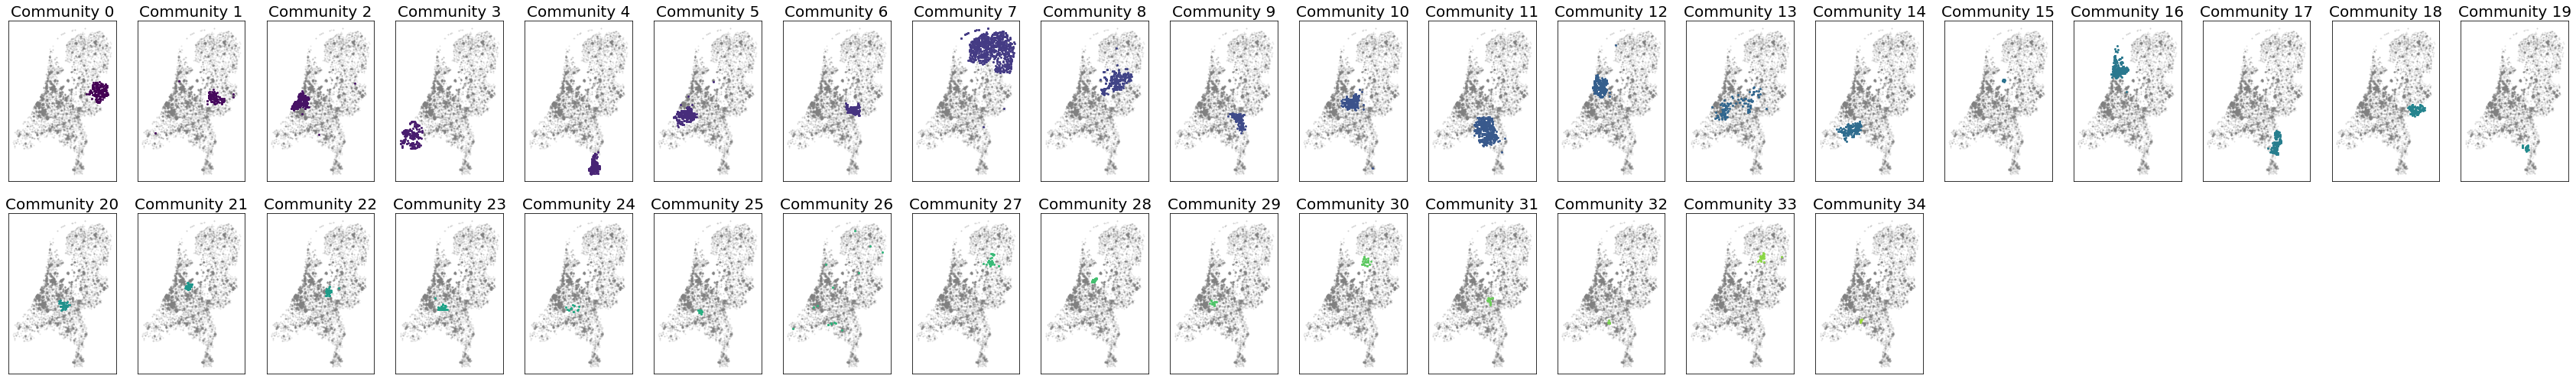

In [142]:
for consensus in [comps_5] :
    school_data = transnet.school_data
    NUM_COLORS = 40
    cm = plt.get_cmap('viridis')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    fig = plt.figure(figsize=[20*3,17/2.])

    for i, com in enumerate(consensus): 

        ax=fig.add_subplot(2,NUM_COLORS/2,i+1)
        pd.DataFrame(school_data).query('BRIN not in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=2, mfc='Grey', ax=ax, alpha=0.2, mew=0)
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Community ' + str(i), fontsize=20)
        ax.legend([], frameon=False)

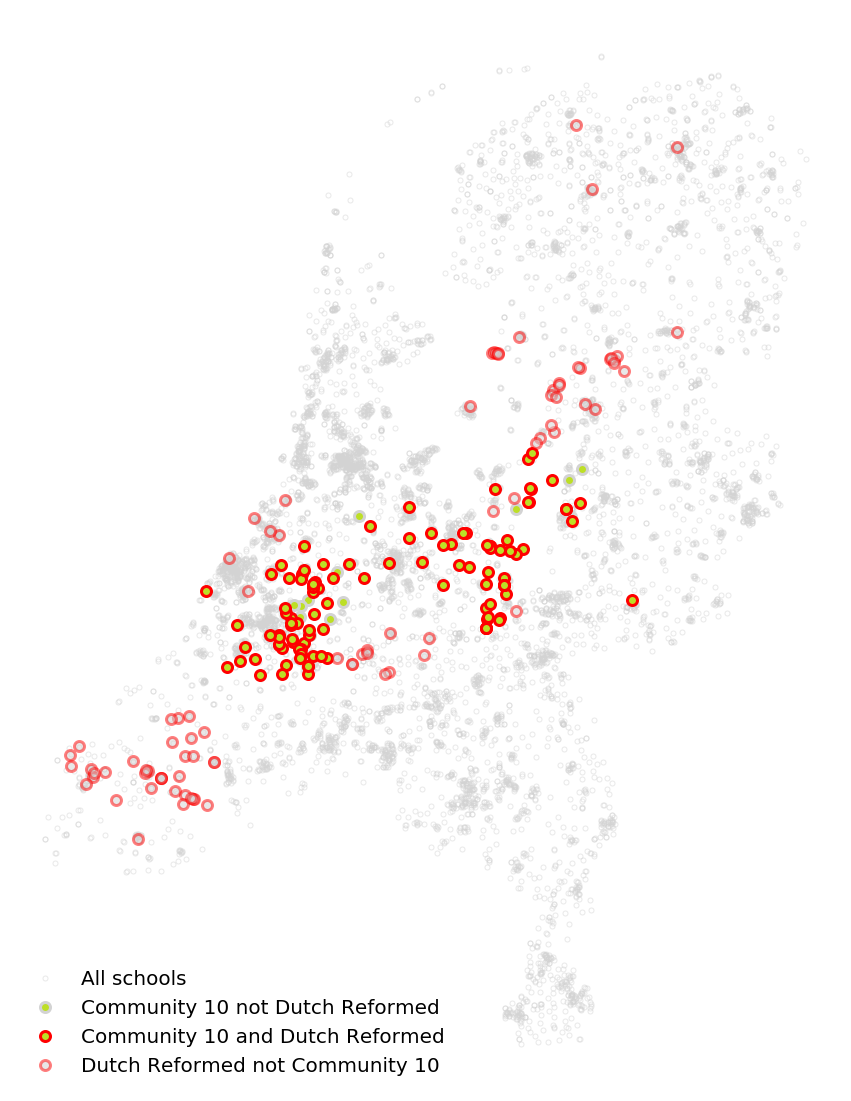

In [144]:
parts = []

for coms in [comps_5]:
    part = dict()
    for i, com in enumerate(coms):
        for n in com:
            part[n] = i
    parts.append(part)

part_frame = pd.DataFrame.from_dict(parts[0], orient='index').reset_index()
part_frame.columns = ['BRIN', 'Part']
school_data_p = transnet.school_data.merge(part_frame, on='BRIN', how='inner')


    
fig = plt.figure(figsize=[15,20])
ax=fig.add_subplot(111)


pd.DataFrame(school_data_p).query('Part != 13 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=5, mec='LightGrey', mfc='none', ax=ax, alpha=0.5)
pd.DataFrame(school_data_p).query('Part == 13 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc=cm(0.9), mec='LightGrey', mew=3., ax=ax, alpha=1.)
pd.DataFrame(school_data_p).query('Part == 13 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc=cm(0.9), mec='r', mew=3., ax=ax, alpha=1.)
pd.DataFrame(school_data_p).query('Part != 13 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc='LightGrey', mec='r', mew=3., ax=ax, alpha=0.5)



sns.despine(left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_title('', fontsize=20)
ax.legend(['All schools', 'Community 10 not Dutch Reformed','Community 10 and Dutch Reformed','Dutch Reformed not Community 10' ], fontsize=20, frameon=0)

In [146]:
com2 = comps_5[13]
school_data[(school_data.BRIN.isin(com2))].groupby(['provincie', 'Denomination']).count()[['BRIN']].rename(columns={'BRIN':"InCom"})

InCom
provincie     Denomination                  
Gelderland    Protestants-Christelijk      3
              Reformatorisch              38
Noord-Holland Reformatorisch               1
Utrecht       Protestants-Christelijk      2
              Reformatorisch              14
Zuid-Holland  Protestants-Christelijk      8
              Reformatorisch              54

In [148]:
school_data[(school_data.BRIN.isin(com2))].groupby(['provincie', 'Denomination']).count()[['BRIN']].rename(columns={'BRIN':"InCom"}).to_csv("allwaysshared.csv")

In [147]:
school_data[(school_data.BRIN.isin(com2))].groupby(['Denomination']).count()[['BRIN']].rename(columns={'BRIN':"InCom"})

InCom
Denomination                  
Protestants-Christelijk     13
Reformatorisch             107

In [ ]:
for consensus in [comps_list_mp]:
    school_data = transnet.school_data
    NUM_COLORS = 40
    cm = plt.get_cmap('plasma')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    fig = plt.figure(figsize=[70,5])

    for j,i  in enumerate(np.where(np.array([len(comp) for comp in comps_list_mp]) > 5)[0]): 
        com = consensus[i]
        ax=fig.add_subplot(1,NUM_COLORS,j+1)
        pd.DataFrame(school_data).query('BRIN not in @com').plot(x='x_coord', y='y_coord', 
                                                                    style='o',ms=2, mfc='Grey', ax=ax, alpha=0.2, mew=0)
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                    style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                    alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Community ' + str(i), fontsize=20)
        ax.legend([])

In [486]:
com4 = comps_list_mp[10]
school_data[(school_data.BRIN.isin(com4))].groupby(['provincie', 'Denomination']).count().BRIN

provincie      Denomination           
Gelderland     Protestants-Christelijk     7
               Reformatorisch             42
Noord-Brabant  Protestants-Christelijk     2
               Reformatorisch              4
Noord-Holland  Reformatorisch              2
Overijssel     Reformatorisch              7
Utrecht        Protestants-Christelijk     4
               Reformatorisch             16
Zuid-Holland   Protestants-Christelijk    12
               Reformatorisch             59
Name: BRIN, dtype: int64

In [479]:
np.where(np.array([len(comp) for comp in comps_list_mp]) > 5)[0]

array([], dtype=int64)

In [480]:
np.array([len(comp) for comp in comps_list_mp]) 

array([], dtype=float64)

In [481]:
comps_list_mp

[]

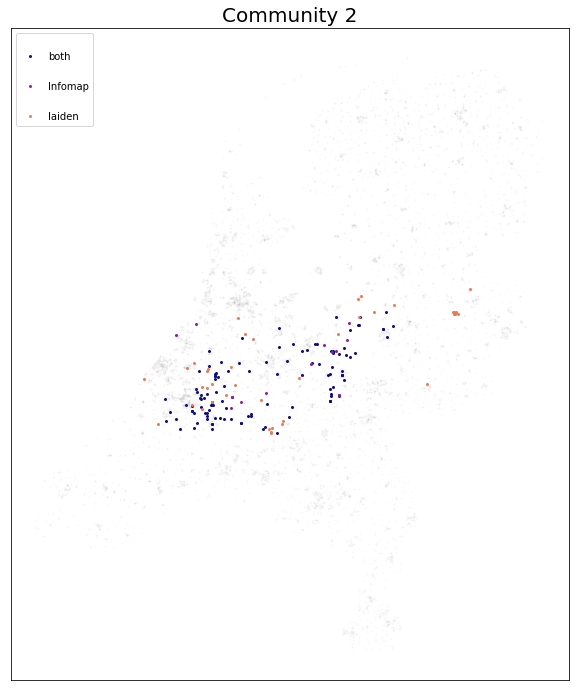

In [516]:
for consensus in [[np.intersect1d(com2,list(com4)),np.setdiff1d(com2,list(com4)), np.setdiff1d(list(com4),com2)]]:
    school_data = transnet.school_data
    NUM_COLORS = 3
    cm = plt.get_cmap('plasma')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    fig = plt.figure(figsize=[10,12])
    ax=fig.add_subplot(1,1,1)

    for i,com  in enumerate(consensus): 
        
       
        pd.DataFrame(school_data).query('BRIN not in @com').plot(x='x_coord', y='y_coord', 
                                                                    style='o',ms=2, mfc='Grey', ax=ax, alpha=0.01, mew=0)
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                    style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                    alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Community ' + str(i), fontsize=20)
        ax.legend(['','both', '', 'Infomap', '', "laiden",])

In [495]:
len(np.intersect1d(com2, list(com4)))

115

In [441]:
sim_mat == 

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [194]:
np.fill_diagonal(sim_mat_all, 0 )
maxs = np.array([min(1.0, max(s)) for s in sim_mat_all])

In [195]:
np.unique(maxs)

array([0.55, 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [196]:
most_probable_shared = (sim_mat_all == maxs)*1.

In [197]:
most_probable_shared_net = transnet.create_network_from_transmat_undi(most_probable_shared, nodelist_sm)

In [198]:
most_probable_shared_net= most_probable_shared_net.to_undirected()

In [199]:
comps_mp = nx.components.connected_components(most_probable_shared_net)

In [200]:
comps_list_mp = list(comps_mp)

In [ ]:
len(comps_list_mp)

ValueError: num must be 1 <= num <= 46, not 47

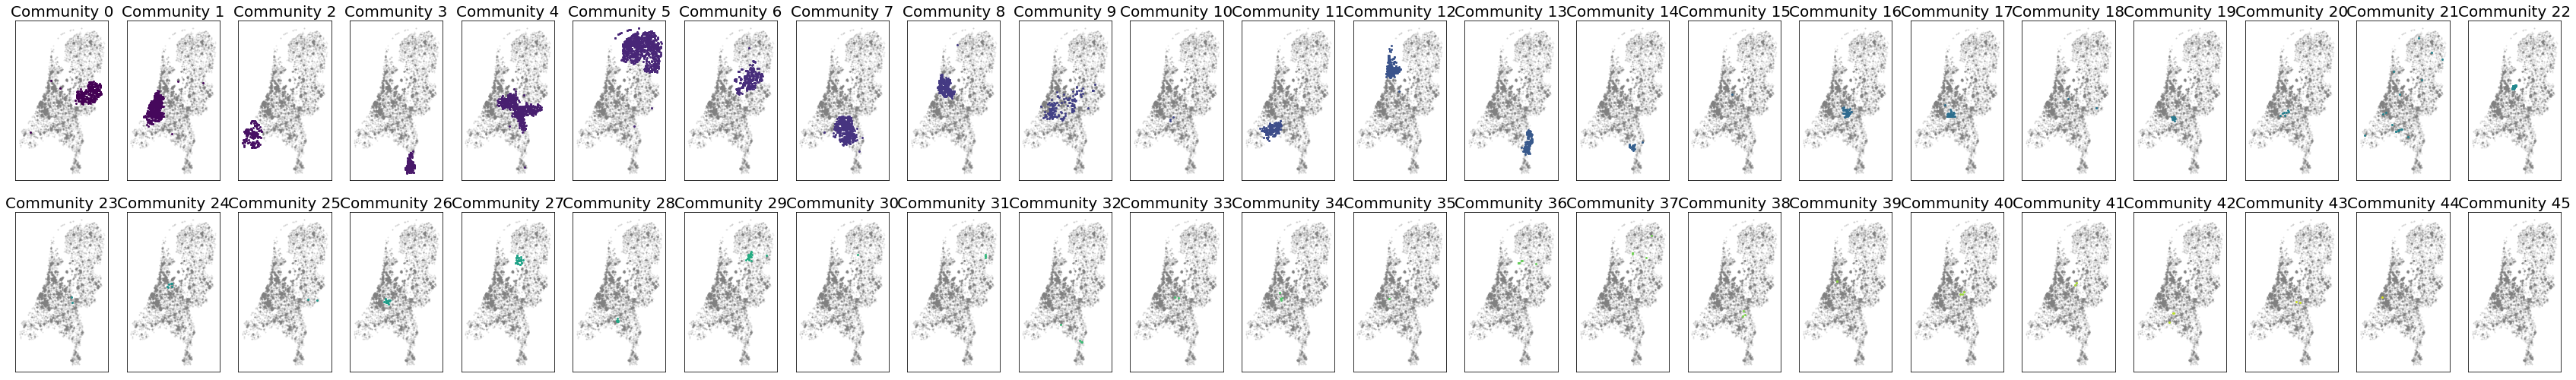

In [202]:
for consensus in [comps_list_mp] :
    school_data = transnet.school_data
    NUM_COLORS = 47
    cm = plt.get_cmap('viridis')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    fig = plt.figure(figsize=[20*3,17/2.])

    for i, com in enumerate(consensus): 

        ax=fig.add_subplot(2,NUM_COLORS/2,i+1)
        pd.DataFrame(school_data).query('BRIN not in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=2, mfc='Grey', ax=ax, alpha=0.2, mew=0)
        pd.DataFrame(school_data).query('BRIN in @com').plot(x='x_coord', y='y_coord', 
                                                                style='o',ms=3, mfc=cm(i/float(NUM_COLORS)), ax=ax, 
                                                                alpha=1., mew=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_title('Community ' + str(i), fontsize=20)
        ax.legend([], frameon=False)

In [ ]:
parts = []

for coms in [comps_list_mp]:
    part = dict()
    for i, com in enumerate(coms):
        for n in com:
            part[n] = i
    parts.append(part)

part_frame = pd.DataFrame.from_dict(parts[0], orient='index').reset_index()
part_frame.columns = ['BRIN', 'Part']
school_data_p = transnet.school_data.merge(part_frame, on='BRIN', how='inner')


    
fig = plt.figure(figsize=[15,20])
ax=fig.add_subplot(111)


pd.DataFrame(school_data_p).query('Part != 9 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=5, mec='LightGrey', mfc='none', ax=ax, alpha=0.5)
pd.DataFrame(school_data_p).query('Part == 9 and Denomination != "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc=cm(0.9), mec='LightGrey', mew=3., ax=ax, alpha=1.)
pd.DataFrame(school_data_p).query('Part == 9 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc=cm(0.9), mec='r', mew=3., ax=ax, alpha=1.)
pd.DataFrame(school_data_p).query('Part != 9 and Denomination == "Reformatorisch"').plot(x='x_coord', y='y_coord', style='o',ms=10, mfc='LightGrey', mec='r', mew=3., ax=ax, alpha=0.5)



sns.despine(left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_title('', fontsize=20)
ax.legend(['All schools', 'Community 10 not Dutch Reformed','Community 10 and Dutch Reformed','Dutch Reformed not Community 10' ], fontsize=20, frameon=0)

In [667]:
mp_compss = []
for p in np.arange(0.5, 1.1, 0.1):
    maxs = np.array([min(p, max(s)) for s in sim_mat_all/10.])
    most_probable_shared = ((sim_mat_all/10.) > maxs)*1.
    most_probable_shared_net = transnet.create_network_from_transmat_undi(most_probable_shared, nodelist_sm)
    comps_mp = nx.components.connected_components(most_probable_shared_net)
    comps_list_mp = list(comps_mp)
    mp_compss.append(cdlib.NodeClustering(communities =comps_list_mp, 
                                          graph = transnet.data_net.subgraph(nodes=nodelist_sm), 
                                          method_name ="most_probable_coms_ens", method_parameters=None, 
                                          overlap=False))

In [675]:
nmis = [mpc.normalized_mutual_information(im_coms).score for mpc in mp_compss]
surs = [mpc.surprise().score for mpc in mp_compss]
mods = [mpc.newman_girvan_modularity().score for mpc in mp_compss]
lcms = [len(mpc.communities) for mpc in mp_compss]

In [663]:
consensuses_2[0]

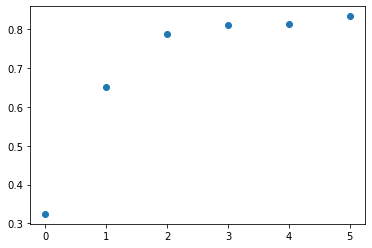

In [691]:
plt.plot(nmis[:-1], 'o')

In [611]:
comps_mp = nx.components.connected_components(most_probable_shared_net)

In [612]:
list_comps_mp = list(comps_mp)

In [613]:
len([len(c) for c in list_comps_mp])

66

In [614]:
comps_list_mp = list_comps_mp

In [616]:
mp_coms = cdlib.NodeClustering(communities =comps_list_mp, graph = transnet.data_net.subgraph(nodes=nodelist_sm) , method_name ="most_probable_coms_ens", method_parameters=None, overlap=False)

In [689]:
nmi = [leiden.normalized_mutual_information(im_coms).score for leiden in leidens]

(array([ 4.,  2.,  9., 13., 12., 20., 15., 10., 12.,  3.]),
 array([0.7587123 , 0.76382559, 0.76893888, 0.77405217, 0.77916545,
        0.78427874, 0.78939203, 0.79450531, 0.7996186 , 0.80473189,
        0.80984518]),
 <a list of 10 Patch objects>)

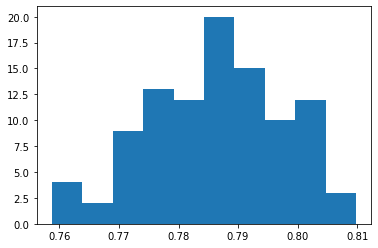

In [690]:
plt.hist(nmi)

In [617]:
mp_coms.normalized_mutual_information(im_coms)

MatchingResult(score=0.8157085925300389, std=None)

In [593]:
mp_coms.internal_edge_density()

FitnessResult(min=0.0, max=0.25, score=0.07440101780446824, std=0.0881594515471481)

In [571]:
im_coms = algorithms.infomap(transnet.data_net.subgraph(nodes = nodelist_sm))

In [58]:
componetns = list(nx.components.connected_components(transnet.data_net))

In [62]:
len(componetns[0])

9200

In [98]:
h, b = np.histogram(list(dict(nx.degree(transnet.data_net)).values()), bins = np.arange(0,7000,10) )

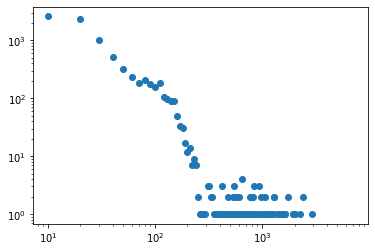

In [99]:
plt.plot(b[:-1], h, 'o')
plt.yscale('log')
plt.xscale('log')

In [96]:
degframe = pd.DataFrame.from_dict(dict(nx.degree(transnet.data_net, weight='weight')), orient='index', columns=['Degree']).reset_index().rename(columns={'index':'BRIN'})

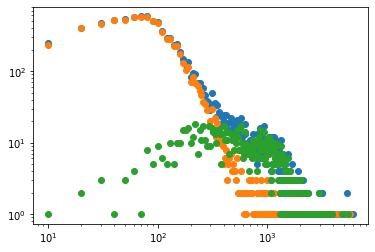

In [102]:
h, b = np.histogram(degframe.Degree, bins = np.arange(0,6000,10) )
plt.plot(b[:-1], h, 'o')
plt.yscale('log')
plt.xscale('log')

h, b = np.histogram(degframe[degframe.BRIN.isin(pri_brin)].Degree, bins = np.arange(0,6000,10) )
plt.plot(b[:-1], h, 'o')
plt.yscale('log')
plt.xscale('log')

h, b = np.histogram(degframe[degframe.BRIN.isin(sec_brin)].Degree, bins = np.arange(0,6000,10) )
plt.plot(b[:-1], h, 'o')
plt.yscale('log')
plt.xscale('log')

In [90]:
pri_brin = np.array(transnet.school_data[transnet.school_data.kind == 'pri'].BRIN)
sec_brin = np.array(transnet.school_data[transnet.school_data.kind == 'sec'].BRIN)

In [ ]:
allwaysshared = (sim_mat == 1)*1.

In [ ]:
allwaysshared_net = transnet.create_network_from_transmat_undi(allwaysshared, np.array(school_data_p.sort_values(['BRIN']).BRIN))

In [ ]:
allwaysshared_net= allwaysshared_net.to_undirected()

In [ ]:
comps = nx.components.connected_components(allwaysshared_net)